In [1]:
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



#  TiSeLaC : Time Series Land Cover Classification Challenge 

This challenge originating from [this website](https://sites.google.com/site/dinoienco/tiselc) challenges anyone who is interested to deal with SITS (Satellite Imagery Time Series).

The challenge involves a multi-class single label classification problem where the examples to classify are pixels described by the time series of satellite images and the prediction is related to the land cover of associated to each pixel:
<br>
<figure>
       <img src="static/img/time_series_classification.png" alt="time_series_classification" width="600">
          <figcaption>Fig.1 - The Reunion Island site (a) and the corresponding classification according to the considered Land Cover Classes (b)</figcaption>
</figure>
<br>


Before going in the EDA phase, we will first detail what our dataset is made of:
<figure>
       <img src="static/img/tiselac_pres_1.png" alt="tiselac_pres_1" width="600">
          <figcaption>Fig.2 - A visual description of the dataset (b)</figcaption>
</figure>

## Data presentation

### Training classes

The classes found in the *training_class.txt* file are the following:


| Class ID | Class Name              | # Instances |
|----------|-------------------------|-------------|
| 1        | Urban Areas             | 16000       |
| 2        | Other built-up surfaces | 3236        |
| 3        | Forests                 | 16000       |
| 4        | Sparse Vegetation       | 16000       |
| 5        | Rocks and bare soil     | 12942       |
| 6        | Grassland               | 5681        |
| 7        | Sugarcane crops         | 7656        |
| 8        | Other crops             | 1600        |
| 9        | Water                   | 2599        |

where the instances designates the pixels that makes up the image (total of 81714 pixels). It is important to note that not all pixel has a class, some are left blank.

### Training file

The training file is in the form of a big text file where each row represents the value of the features of the given pixel at the 23 dates. As each pixel is described by 10 features (always in the following order: (Ultra Blue, Blue, Green, Red, NIR, SWIR1, SWIR2, NDVI, NDWI, BI), we have, for each row, 10*23 columns.

### Coordinates file

This file gives the actual coordinates of pixels associated with a class to be able to draw a mask on the initial map of The Reunion Island.

## Analysis of the source images

We will first explore the RGB component of the source images in the training file by redrawing its components.

In [137]:
# CONSTANTS & IMPORTS
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import seaborn as sns;sns.set()

IMAGE_SIZE = (2866, 2633, 3)
NUM_OF_DAYS = 23
CLASSES = ["urban areas", "other built-up surfaces", "forests", 
           "sparse vegetation", "rocks and bare soil", "grassland", 
           "sugarcane crops", "other crops", "water"]
FEATURES = [
    "ultra blue","blue","green","red","NIR","SWIR1","SWIR2","NDVI","NDWI","BI"
]

NUM_OF_CLASSES = len(CLASSES)
NUM_OF_FEATURES = len(FEATURES)
NUM_OF_PIXELS = 81714

In [164]:
# DATA LOADING
data = pd.read_csv("data/train/training.txt", header=None)
coord = pd.read_csv("data/train/coord_training.txt", header=None)
classes_val = pd.read_csv("data/train/training_class.txt", header=None)

data_test = pd.read_csv("data/test/test.txt", header=None)
coord_test = pd.read_csv("data/test/coord_test.txt", header=None)
classes_val_test = pd.read_csv("data/test/test_class.txt", header=None)
y_test = classes_val_test.to_numpy()

In [27]:
img = [np.zeros(IMAGE_SIZE).astype(np.uint8) for _ in range(NUM_OF_DAYS)]
def row_to_img(row):
    
    idx = row.name
    
    coord_row = coord.iloc[idx, :]

    for i in range(23):
        b = row[i*10+1]
        g = row[i*10+2]
        r = row[i*10+3]
        
        #b = 255
        #g = 255
        #r = 255
        
        if (r > 255):
            r = 255
        if (b > 255):
            b = 255
        if (g > 255):
            g = 255
        
        img[i][coord_row[0], coord_row[1], :] = [r,g,b]
        
tqdm.pandas()
data.progress_apply(row_to_img, axis=1)
print("Images updated")


  3%|█████                                                                                                                                                         | 2590/81714 [00:03<01:54, 688.96it/s]


  6%|██████████▏                                                                                                                                                   | 5260/81714 [00:07<02:00, 634.89it/s]


 10%|███████████████▎                                                                                                                                              | 7906/81714 [00:11<01:53, 651.94it/s]


 13%|████████████████████▍                                                                                                                                        | 10612/81714 [00:15<01:42, 694.14it/s]


 16%|█████████████████████████▊                                                                                                                                   | 13419/81714 [00:19<01:35, 714.93it/s]


 20%|███████████████████████████████▎                                                                                                                             | 16296/81714 [00:23<01:30, 725.85it/s]


 23%|████████████████████████████████████▋                                                                                                                        | 19104/81714 [00:27<01:37, 643.03it/s]


 25%|███████████████████████████████████████▋                                                                                                                     | 20646/81714 [00:30<01:26, 702.91it/s]

KeyboardInterrupt: 

### Checking the classes distribution

The subsampling of the pixels done by the TiSeLaC organizers had, as a first intent, the idea of balancing the classes distribution. We are then expecting to see a somewhat balanced dataset.

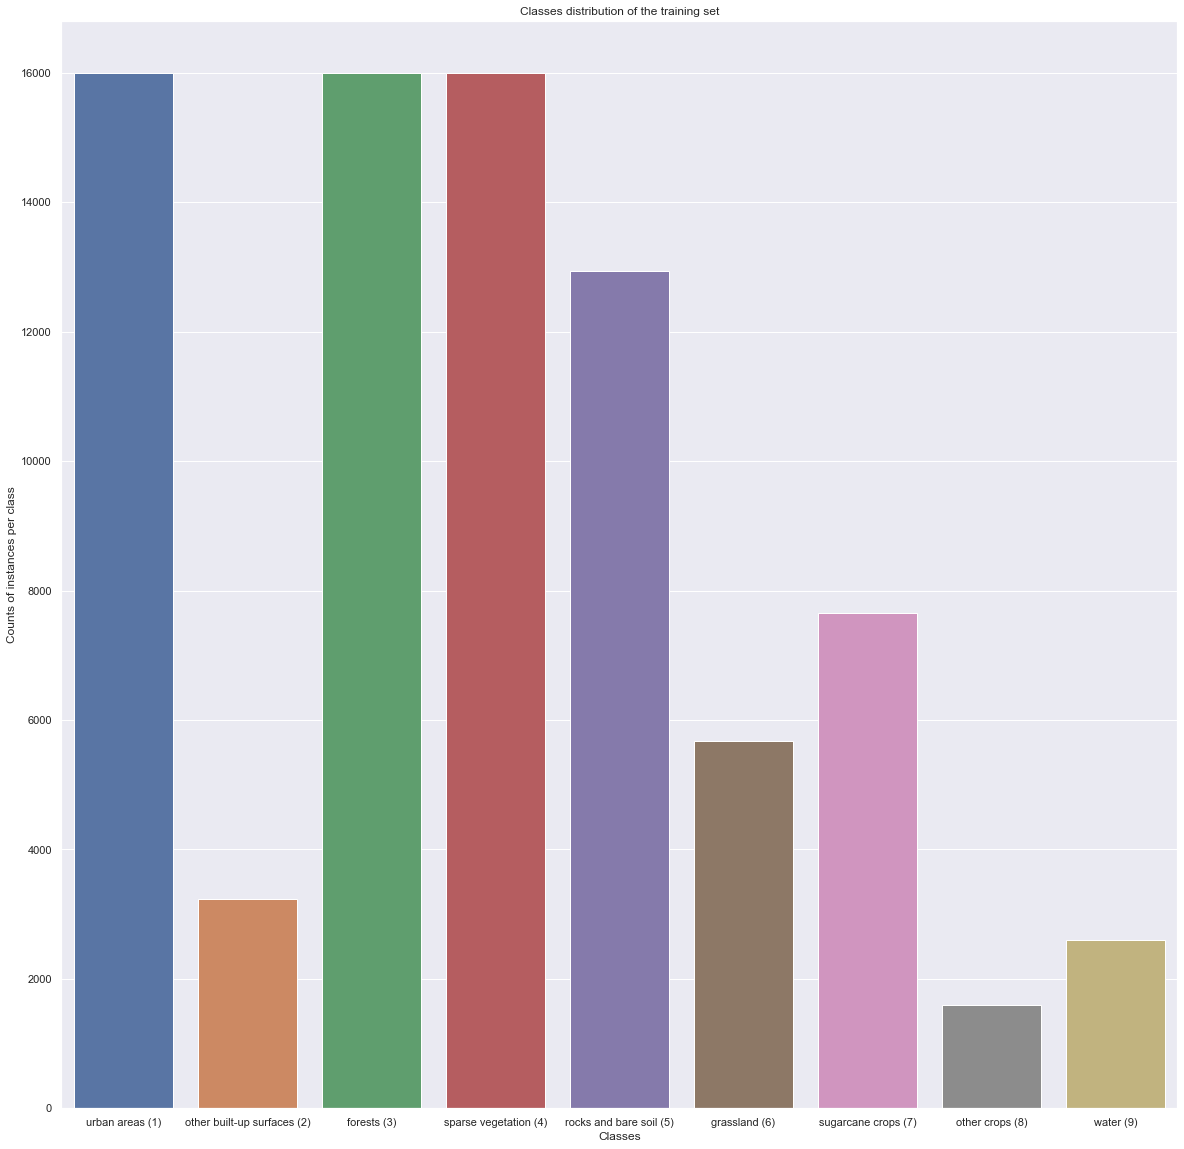

In [169]:
val_count = classes_val.iloc[:,0].value_counts().sort_index()
x, y = val_count.keys(), val_count.values
plt.figure(figsize = (20,20))
ax = sns.barplot([CLASSES[i] + f" ({i+1})" for i in range(len(CLASSES))], y)
ax.set_title("Classes distribution of the training set")
ax.set_ylabel("Counts of instances per class")
ax.set_xlabel("Classes")
plt.show()

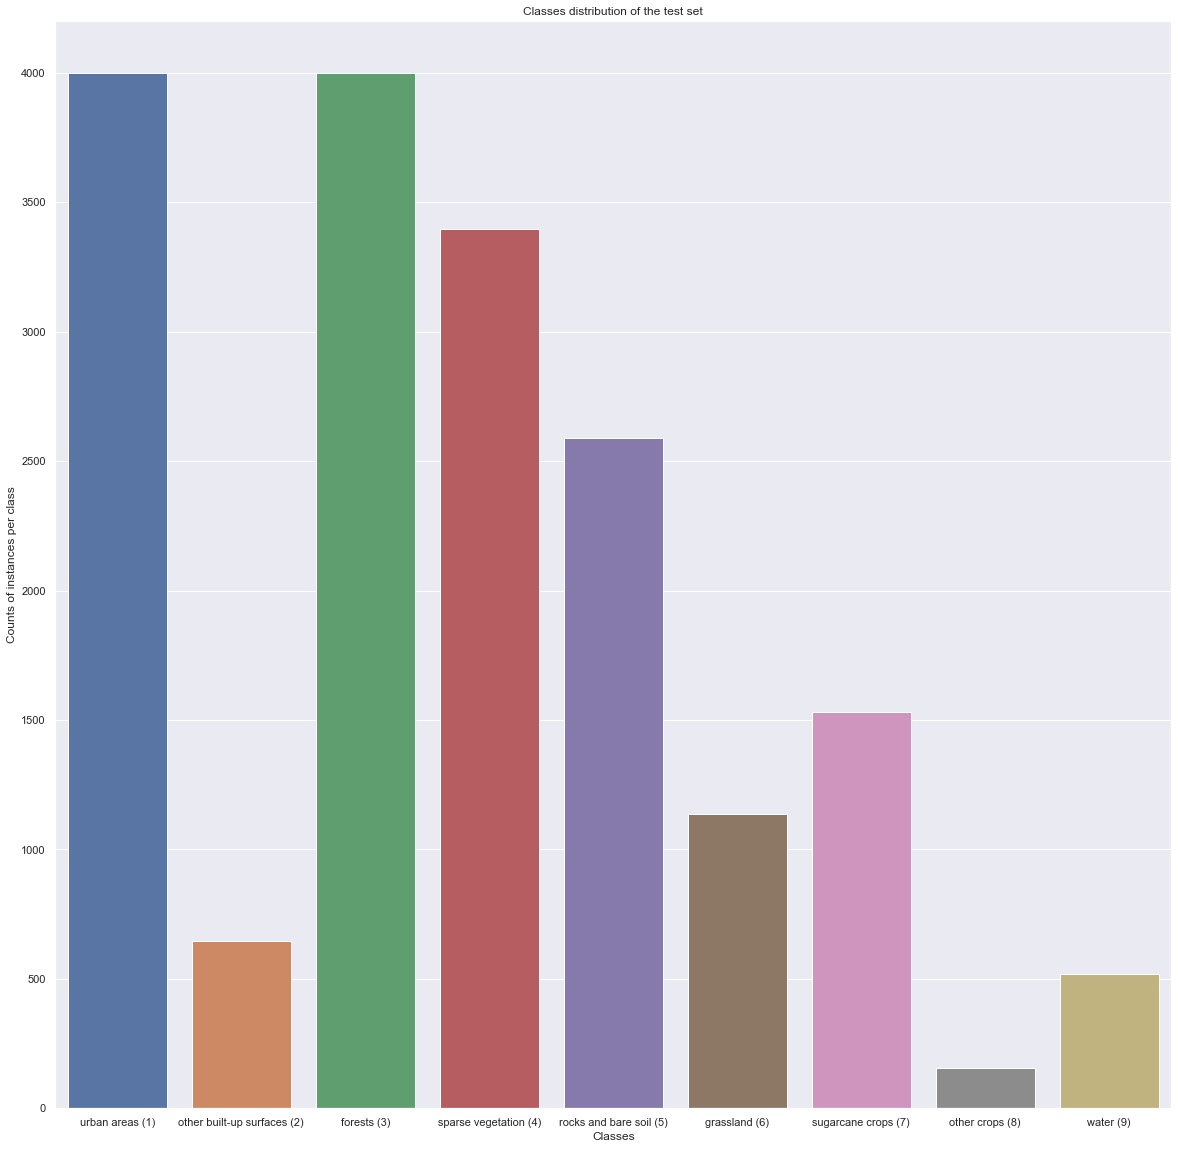

In [170]:
val_count = classes_val_test.iloc[:,0].value_counts().sort_index()
x, y = val_count.keys(), val_count.values
plt.figure(figsize = (20,20))
ax = sns.barplot([CLASSES[i] + f" ({i+1})" for i in range(len(CLASSES))], y)
ax.set_title("Classes distribution of the test set")
ax.set_ylabel("Counts of instances per class")
ax.set_xlabel("Classes")
plt.show()

### Plotting the 23 days images of the 81714 pixels

As out of the 2866*2633 pixels, only 81714 were retained, we cannot have a good overview of their position and variation in the images presented there. However, a few things are important to point out:
 - We can notice clearly the shape of the Reunion island from the original image shown above
 - Some changes in noticeable clusters of pixels can be observed, especially at the bottom right of the image

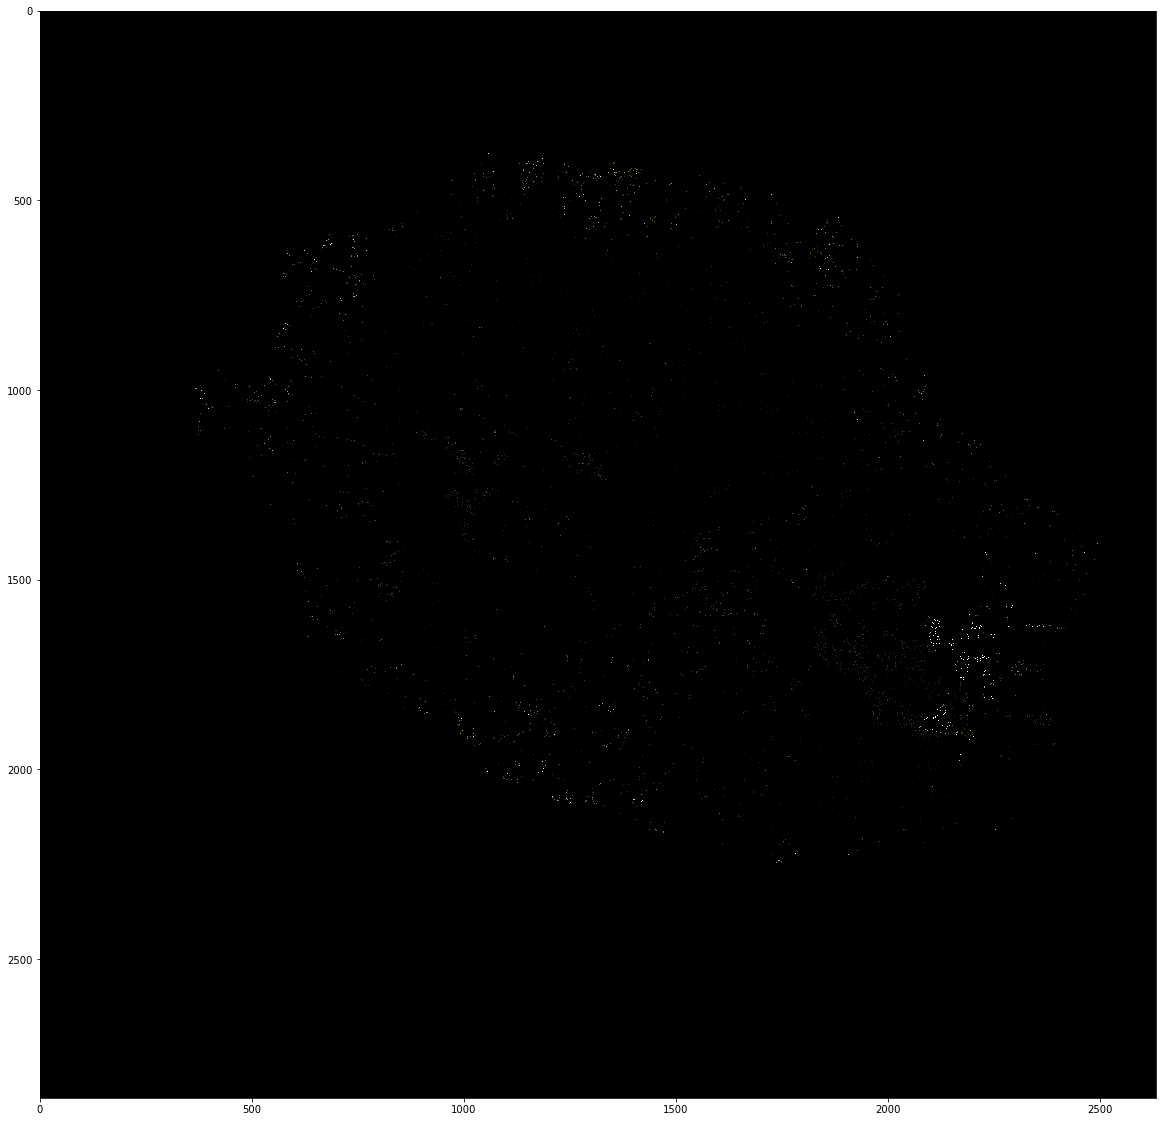

In [52]:
plt.figure(figsize = (20,20))
plt.imshow(img[13], aspect='auto')

In [53]:
# creating the gif
import imageio

# Write some Text

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (1050,2600)
fontScale              = 5
fontColor              = (255,255,255)
lineType               = 4
thickness              = 10

scale_percent = 65 # percent of original size
width = int(img[0].shape[1] * scale_percent / 100)
height = int(img[0].shape[0] * scale_percent / 100)
dim = (width, height)
# resize image

with imageio.get_writer('day_animation.gif', mode='I') as writer:
    for i in range(0,NUM_OF_DAYS):
        for j in range(5):
            img_d = np.copy(img[i])
            cv2.putText(img_d,f'Day {i+1}', 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                thickness,
                lineType)
            resized = cv2.resize(img_d, dim, interpolation = cv2.INTER_NEAREST) 
            writer.append_data(resized)

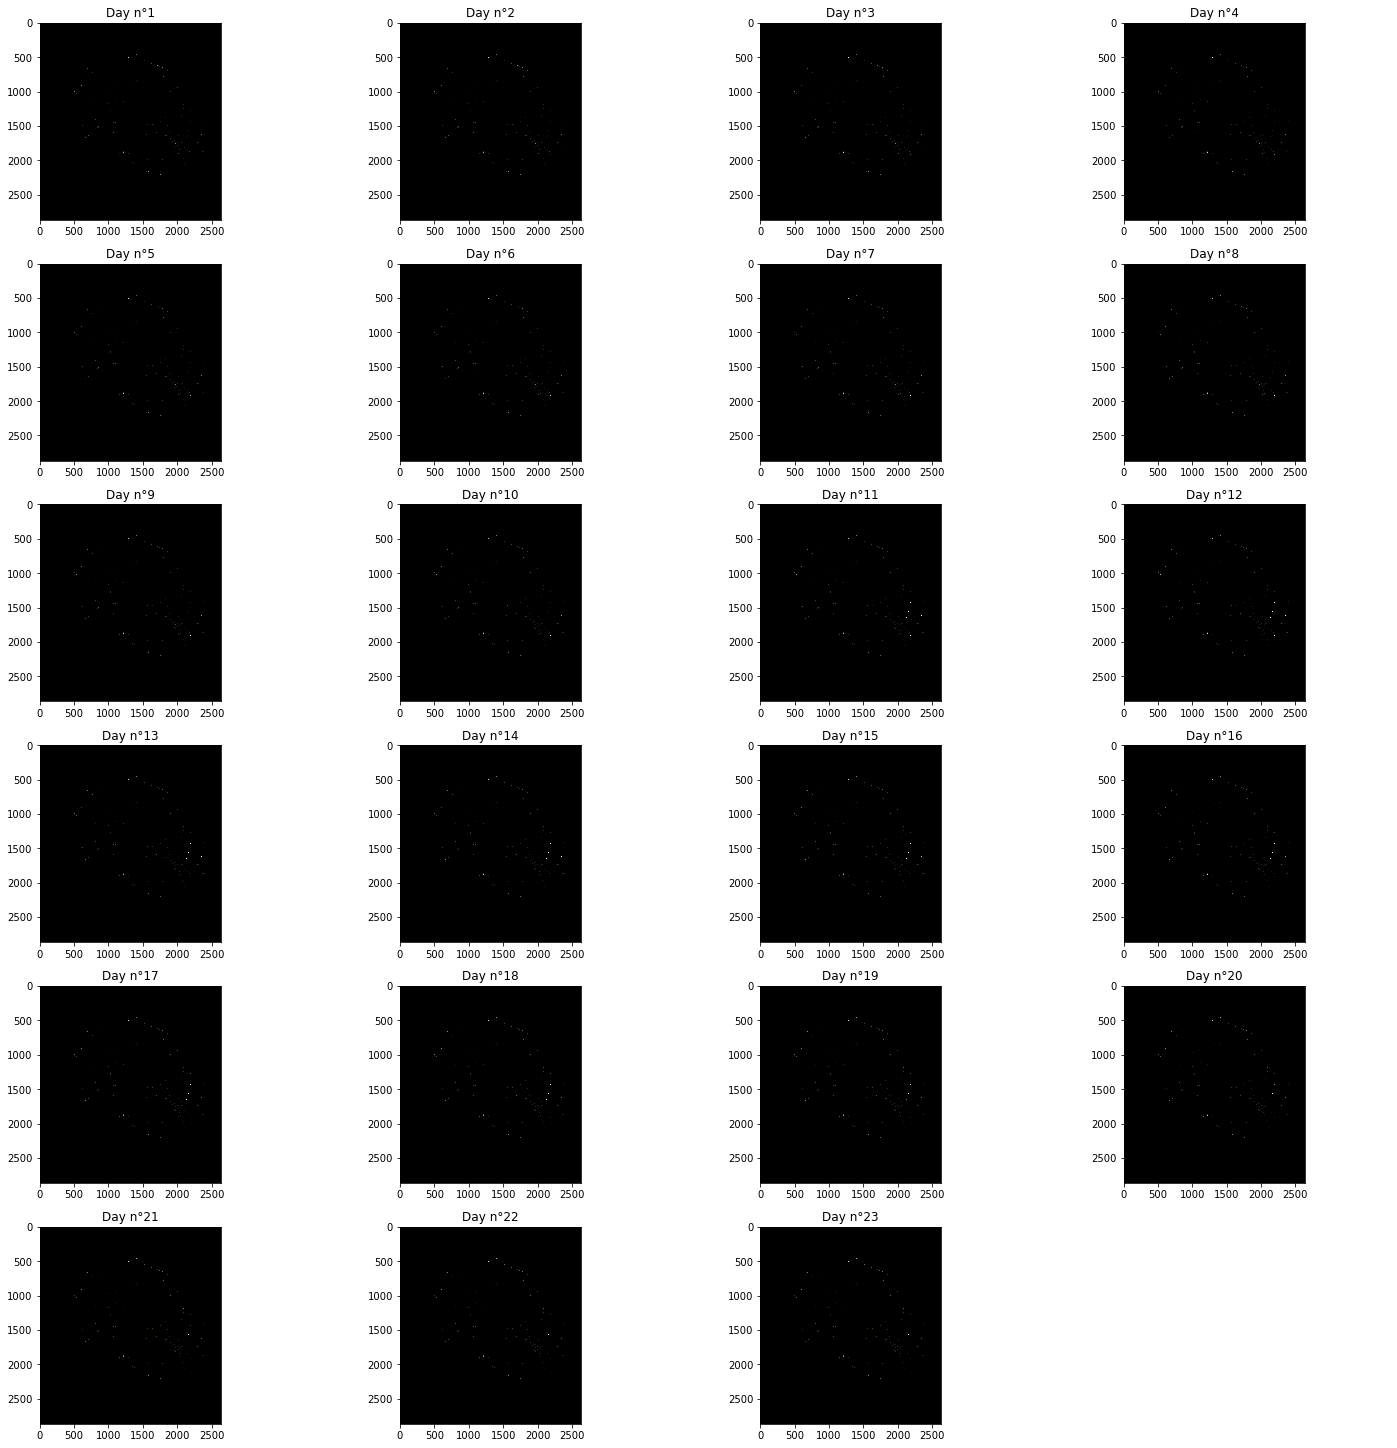

In [49]:
fig, axs=plt.subplots(6, 4, figsize=(20, 20), constrained_layout=True)

for i in range(0,NUM_OF_DAYS):
    
    x = int(i / 4)
    y = i % 4
    
    axs[x, y].imshow(img[i])
    
    axs[x,y].set_title(f'Day n°{i+1}')

fig.delaxes(axs[5,3])
#fig.tight_layout()

### Giving insights on mean value of the 10 features over the 23 days, discriminated by class

In order to see if we can extract any pattern ourselves, we will plot the mean value evolution of each feature over the 23 days by calculating the mean of these values for each class, resulting in one plot per class, with 10 lines on each plots.

In [54]:
# we start by building an array of 10 matrices of size 10*23 each

list_of_per_class_features_mean = [
    np.zeros((10,23)) for _ in range(len(CLASSES))
]

list_of_per_class_features_std = [
    np.zeros((10,23)) for _ in range(len(CLASSES))
]

N = data.shape[0]

def row_to_class(row):
    
    idx = row.name
    
    class_val = int(classes_val.iloc[idx, 0])
    
    # designates the feature
    for i in range(10):
        # designates the day
        for j in range(23):
            
            list_of_per_class_features_mean[class_val-1][i,j] += row[j*10 + i] # calculating the mean value
            
            list_of_per_class_features_std[class_val-1][i,j] += row[j*10 + i]*row[j*10 + i]/N
    
data.progress_apply(row_to_class, axis=1)
print("Calculation over..")



  0%|                                                                                                                                                                          | 0/81714 [00:00<?, ?it/s]

  0%|                                                                                                                                                                | 1/81714 [00:00<2:18:32,  9.83it/s]

  0%|                                                                                                                                                               | 15/81714 [00:00<1:39:59, 13.62it/s]

  0%|                                                                                                                                                               | 28/81714 [00:00<1:13:18, 18.57it/s]

  0%|                                                                                                                                                                 | 41/81714 [00:00<54

  1%|▉                                                                                                                                                              | 490/81714 [00:04<10:49, 125.07it/s]

  1%|▉                                                                                                                                                              | 504/81714 [00:04<10:40, 126.85it/s]

  1%|█                                                                                                                                                              | 517/81714 [00:04<10:39, 126.93it/s]

  1%|█                                                                                                                                                              | 530/81714 [00:04<10:51, 124.58it/s]

  1%|█                                                                                                                                                              | 543/81714 [00:04<11:03

  1%|█▉                                                                                                                                                            | 1003/81714 [00:08<10:39, 126.11it/s]

  1%|█▉                                                                                                                                                            | 1016/81714 [00:08<10:39, 126.24it/s]

  1%|█▉                                                                                                                                                            | 1029/81714 [00:08<10:40, 125.97it/s]

  1%|██                                                                                                                                                            | 1042/81714 [00:08<10:38, 126.43it/s]

  1%|██                                                                                                                                                            | 1055/81714 [00:08<10:43

  2%|██▉                                                                                                                                                           | 1524/81714 [00:12<10:38, 125.55it/s]

  2%|██▉                                                                                                                                                           | 1537/81714 [00:12<10:42, 124.76it/s]

  2%|██▉                                                                                                                                                           | 1551/81714 [00:12<10:22, 128.71it/s]

  2%|███                                                                                                                                                           | 1565/81714 [00:12<10:20, 129.09it/s]

  2%|███                                                                                                                                                           | 1578/81714 [00:12<10:35

  3%|███▉                                                                                                                                                          | 2051/81714 [00:16<10:40, 124.40it/s]

  3%|███▉                                                                                                                                                          | 2066/81714 [00:16<10:16, 129.09it/s]

  3%|████                                                                                                                                                          | 2080/81714 [00:16<10:09, 130.71it/s]

  3%|████                                                                                                                                                          | 2094/81714 [00:16<10:15, 129.31it/s]

  3%|████                                                                                                                                                          | 2107/81714 [00:16<10:21

  3%|████▉                                                                                                                                                         | 2570/81714 [00:20<10:33, 124.99it/s]

  3%|████▉                                                                                                                                                         | 2583/81714 [00:20<10:32, 125.09it/s]

  3%|█████                                                                                                                                                         | 2596/81714 [00:20<10:34, 124.62it/s]

  3%|█████                                                                                                                                                         | 2609/81714 [00:20<10:35, 124.48it/s]

  3%|█████                                                                                                                                                         | 2622/81714 [00:21<10:28

  4%|█████▉                                                                                                                                                        | 3089/81714 [00:24<10:09, 129.02it/s]

  4%|█████▉                                                                                                                                                        | 3102/81714 [00:24<10:40, 122.83it/s]

  4%|██████                                                                                                                                                        | 3115/81714 [00:24<10:30, 124.63it/s]

  4%|██████                                                                                                                                                        | 3128/81714 [00:25<10:31, 124.49it/s]

  4%|██████                                                                                                                                                        | 3141/81714 [00:25<10:33

  4%|██████▉                                                                                                                                                       | 3613/81714 [00:28<10:09, 128.14it/s]

  4%|███████                                                                                                                                                       | 3627/81714 [00:28<10:04, 129.25it/s]

  4%|███████                                                                                                                                                       | 3641/81714 [00:29<09:58, 130.36it/s]

  4%|███████                                                                                                                                                       | 3655/81714 [00:29<10:05, 128.81it/s]

  4%|███████                                                                                                                                                       | 3669/81714 [00:29<10:05

  5%|████████                                                                                                                                                      | 4150/81714 [00:32<09:51, 131.06it/s]

  5%|████████                                                                                                                                                      | 4164/81714 [00:33<09:51, 131.10it/s]

  5%|████████                                                                                                                                                      | 4178/81714 [00:33<09:50, 131.30it/s]

  5%|████████                                                                                                                                                      | 4192/81714 [00:33<09:54, 130.34it/s]

  5%|████████▏                                                                                                                                                     | 4206/81714 [00:33<09:58

  6%|█████████                                                                                                                                                     | 4676/81714 [00:37<09:56, 129.15it/s]

  6%|█████████                                                                                                                                                     | 4690/81714 [00:37<09:55, 129.40it/s]

  6%|█████████                                                                                                                                                     | 4703/81714 [00:37<10:00, 128.15it/s]

  6%|█████████                                                                                                                                                     | 4716/81714 [00:37<10:04, 127.29it/s]

  6%|█████████▏                                                                                                                                                    | 4729/81714 [00:37<10:04

  6%|██████████                                                                                                                                                    | 5197/81714 [00:41<09:55, 128.46it/s]

  6%|██████████                                                                                                                                                    | 5210/81714 [00:41<09:58, 127.88it/s]

  6%|██████████                                                                                                                                                    | 5223/81714 [00:41<10:00, 127.47it/s]

  6%|██████████                                                                                                                                                    | 5236/81714 [00:41<09:59, 127.46it/s]

  6%|██████████▏                                                                                                                                                   | 5251/81714 [00:41<09:41

  7%|███████████                                                                                                                                                   | 5732/81714 [00:45<09:40, 130.91it/s]

  7%|███████████                                                                                                                                                   | 5746/81714 [00:45<09:41, 130.63it/s]

  7%|███████████▏                                                                                                                                                  | 5760/81714 [00:45<09:35, 131.90it/s]

  7%|███████████▏                                                                                                                                                  | 5774/81714 [00:45<09:35, 131.87it/s]

  7%|███████████▏                                                                                                                                                  | 5788/81714 [00:45<09:34

  8%|████████████▏                                                                                                                                                 | 6272/81714 [00:49<09:56, 126.49it/s]

  8%|████████████▏                                                                                                                                                 | 6285/81714 [00:49<09:56, 126.51it/s]

  8%|████████████▏                                                                                                                                                 | 6298/81714 [00:49<10:04, 124.71it/s]

  8%|████████████▏                                                                                                                                                 | 6311/81714 [00:49<09:58, 125.98it/s]

  8%|████████████▏                                                                                                                                                 | 6324/81714 [00:49<09:57

  8%|█████████████▏                                                                                                                                                | 6788/81714 [00:53<10:02, 124.40it/s]

  8%|█████████████▏                                                                                                                                                | 6802/81714 [00:53<09:52, 126.36it/s]

  8%|█████████████▏                                                                                                                                                | 6815/81714 [00:53<09:50, 126.79it/s]

  8%|█████████████▏                                                                                                                                                | 6828/81714 [00:53<09:50, 126.87it/s]

  8%|█████████████▏                                                                                                                                                | 6841/81714 [00:53<09:55

  9%|██████████████                                                                                                                                                | 7301/81714 [00:57<09:37, 128.75it/s]

  9%|██████████████▏                                                                                                                                               | 7314/81714 [00:57<09:46, 126.96it/s]

  9%|██████████████▏                                                                                                                                               | 7327/81714 [00:57<09:51, 125.73it/s]

  9%|██████████████▏                                                                                                                                               | 7340/81714 [00:57<09:48, 126.34it/s]

  9%|██████████████▏                                                                                                                                               | 7353/81714 [00:58<09:48

 10%|███████████████                                                                                                                                               | 7814/81714 [01:01<09:47, 125.84it/s]

 10%|███████████████▏                                                                                                                                              | 7827/81714 [01:01<09:47, 125.69it/s]

 10%|███████████████▏                                                                                                                                              | 7840/81714 [01:01<09:43, 126.68it/s]

 10%|███████████████▏                                                                                                                                              | 7853/81714 [01:02<09:41, 126.93it/s]

 10%|███████████████▏                                                                                                                                              | 7866/81714 [01:02<09:47

 10%|████████████████                                                                                                                                              | 8327/81714 [01:05<09:54, 123.47it/s]

 10%|████████████████▏                                                                                                                                             | 8340/81714 [01:05<10:00, 122.28it/s]

 10%|████████████████▏                                                                                                                                             | 8353/81714 [01:06<10:04, 121.46it/s]

 10%|████████████████▏                                                                                                                                             | 8367/81714 [01:06<09:52, 123.89it/s]

 10%|████████████████▏                                                                                                                                             | 8381/81714 [01:06<09:43

 11%|█████████████████                                                                                                                                             | 8834/81714 [01:10<09:58, 121.67it/s]

 11%|█████████████████                                                                                                                                             | 8847/81714 [01:10<09:53, 122.75it/s]

 11%|█████████████████▏                                                                                                                                            | 8861/81714 [01:10<09:42, 125.16it/s]

 11%|█████████████████▏                                                                                                                                            | 8874/81714 [01:10<09:41, 125.22it/s]

 11%|█████████████████▏                                                                                                                                            | 8887/81714 [01:10<10:11

 11%|██████████████████                                                                                                                                            | 9357/81714 [01:14<09:21, 128.82it/s]

 11%|██████████████████                                                                                                                                            | 9371/81714 [01:14<09:19, 129.34it/s]

 11%|██████████████████▏                                                                                                                                           | 9384/81714 [01:14<09:22, 128.49it/s]

 11%|██████████████████▏                                                                                                                                           | 9397/81714 [01:14<09:22, 128.66it/s]

 12%|██████████████████▏                                                                                                                                           | 9410/81714 [01:14<09:24

 12%|███████████████████                                                                                                                                           | 9883/81714 [01:18<09:03, 132.27it/s]

 12%|███████████████████▏                                                                                                                                          | 9897/81714 [01:18<09:08, 130.84it/s]

 12%|███████████████████▏                                                                                                                                          | 9911/81714 [01:18<09:09, 130.76it/s]

 12%|███████████████████▏                                                                                                                                          | 9926/81714 [01:18<08:58, 133.27it/s]

 12%|███████████████████▏                                                                                                                                          | 9940/81714 [01:18<08:53

 13%|████████████████████                                                                                                                                         | 10415/81714 [01:22<09:15, 128.30it/s]

 13%|████████████████████                                                                                                                                         | 10428/81714 [01:22<09:23, 126.52it/s]

 13%|████████████████████                                                                                                                                         | 10441/81714 [01:22<09:24, 126.16it/s]

 13%|████████████████████                                                                                                                                         | 10454/81714 [01:22<09:23, 126.46it/s]

 13%|████████████████████                                                                                                                                         | 10467/81714 [01:22<09:28

 13%|█████████████████████                                                                                                                                        | 10937/81714 [01:26<09:11, 128.28it/s]

 13%|█████████████████████                                                                                                                                        | 10951/81714 [01:26<09:07, 129.14it/s]

 13%|█████████████████████                                                                                                                                        | 10965/81714 [01:26<09:03, 130.11it/s]

 13%|█████████████████████                                                                                                                                        | 10979/81714 [01:26<09:05, 129.71it/s]

 13%|█████████████████████                                                                                                                                        | 10992/81714 [01:26<09:12

 14%|██████████████████████                                                                                                                                       | 11469/81714 [01:30<09:12, 127.05it/s]

 14%|██████████████████████                                                                                                                                       | 11482/81714 [01:30<09:15, 126.53it/s]

 14%|██████████████████████                                                                                                                                       | 11495/81714 [01:30<09:13, 126.90it/s]

 14%|██████████████████████                                                                                                                                       | 11509/81714 [01:30<09:07, 128.33it/s]

 14%|██████████████████████▏                                                                                                                                      | 11522/81714 [01:31<09:07

 15%|███████████████████████                                                                                                                                      | 12004/81714 [01:34<09:11, 126.49it/s]

 15%|███████████████████████                                                                                                                                      | 12017/81714 [01:34<09:14, 125.78it/s]

 15%|███████████████████████                                                                                                                                      | 12030/81714 [01:34<09:14, 125.64it/s]

 15%|███████████████████████▏                                                                                                                                     | 12043/81714 [01:35<09:14, 125.55it/s]

 15%|███████████████████████▏                                                                                                                                     | 12057/81714 [01:35<09:07

 15%|████████████████████████                                                                                                                                     | 12535/81714 [01:38<09:04, 127.12it/s]

 15%|████████████████████████                                                                                                                                     | 12548/81714 [01:38<09:12, 125.26it/s]

 15%|████████████████████████▏                                                                                                                                    | 12561/81714 [01:39<09:09, 125.88it/s]

 15%|████████████████████████▏                                                                                                                                    | 12575/81714 [01:39<09:01, 127.78it/s]

 15%|████████████████████████▏                                                                                                                                    | 12588/81714 [01:39<09:02

 16%|█████████████████████████                                                                                                                                    | 13055/81714 [01:42<09:06, 125.74it/s]

 16%|█████████████████████████                                                                                                                                    | 13068/81714 [01:43<09:01, 126.89it/s]

 16%|█████████████████████████▏                                                                                                                                   | 13081/81714 [01:43<08:57, 127.70it/s]

 16%|█████████████████████████▏                                                                                                                                   | 13094/81714 [01:43<08:57, 127.72it/s]

 16%|█████████████████████████▏                                                                                                                                   | 13107/81714 [01:43<08:57

 17%|██████████████████████████                                                                                                                                   | 13579/81714 [01:47<08:36, 132.01it/s]

 17%|██████████████████████████                                                                                                                                   | 13593/81714 [01:47<08:37, 131.76it/s]

 17%|██████████████████████████▏                                                                                                                                  | 13607/81714 [01:47<08:37, 131.59it/s]

 17%|██████████████████████████▏                                                                                                                                  | 13621/81714 [01:47<08:43, 130.01it/s]

 17%|██████████████████████████▏                                                                                                                                  | 13635/81714 [01:47<08:50

 17%|███████████████████████████                                                                                                                                  | 14114/81714 [01:51<08:42, 129.37it/s]

 17%|███████████████████████████▏                                                                                                                                 | 14127/81714 [01:51<08:51, 127.08it/s]

 17%|███████████████████████████▏                                                                                                                                 | 14140/81714 [01:51<08:55, 126.13it/s]

 17%|███████████████████████████▏                                                                                                                                 | 14154/81714 [01:51<08:47, 127.96it/s]

 17%|███████████████████████████▏                                                                                                                                 | 14167/81714 [01:51<09:14

 18%|████████████████████████████▏                                                                                                                                | 14645/81714 [01:55<08:50, 126.52it/s]

 18%|████████████████████████████▏                                                                                                                                | 14658/81714 [01:55<08:56, 125.07it/s]

 18%|████████████████████████████▏                                                                                                                                | 14672/81714 [01:55<08:42, 128.24it/s]

 18%|████████████████████████████▏                                                                                                                                | 14686/81714 [01:55<08:32, 130.73it/s]

 18%|████████████████████████████▏                                                                                                                                | 14701/81714 [01:55<08:23

 19%|█████████████████████████████▏                                                                                                                               | 15170/81714 [01:59<08:50, 125.46it/s]

 19%|█████████████████████████████▏                                                                                                                               | 15183/81714 [01:59<08:55, 124.35it/s]

 19%|█████████████████████████████▏                                                                                                                               | 15196/81714 [01:59<08:50, 125.36it/s]

 19%|█████████████████████████████▏                                                                                                                               | 15209/81714 [01:59<08:50, 125.35it/s]

 19%|█████████████████████████████▏                                                                                                                               | 15222/81714 [01:59<08:47

 19%|██████████████████████████████▏                                                                                                                              | 15694/81714 [02:03<08:45, 125.67it/s]

 19%|██████████████████████████████▏                                                                                                                              | 15707/81714 [02:03<09:14, 119.04it/s]

 19%|██████████████████████████████▏                                                                                                                              | 15720/81714 [02:03<09:21, 117.59it/s]

 19%|██████████████████████████████▏                                                                                                                              | 15732/81714 [02:03<09:23, 117.01it/s]

 19%|██████████████████████████████▏                                                                                                                              | 15744/81714 [02:03<09:29

 20%|███████████████████████████████▏                                                                                                                             | 16219/81714 [02:07<08:32, 127.86it/s]

 20%|███████████████████████████████▏                                                                                                                             | 16233/81714 [02:07<08:30, 128.31it/s]

 20%|███████████████████████████████▏                                                                                                                             | 16246/81714 [02:07<08:36, 126.66it/s]

 20%|███████████████████████████████▏                                                                                                                             | 16259/81714 [02:07<08:33, 127.55it/s]

 20%|███████████████████████████████▎                                                                                                                             | 16273/81714 [02:07<08:28

 21%|████████████████████████████████▏                                                                                                                            | 16757/81714 [02:11<08:22, 129.37it/s]

 21%|████████████████████████████████▏                                                                                                                            | 16770/81714 [02:11<08:37, 125.56it/s]

 21%|████████████████████████████████▏                                                                                                                            | 16783/81714 [02:11<08:48, 122.83it/s]

 21%|████████████████████████████████▎                                                                                                                            | 16796/81714 [02:12<08:46, 123.22it/s]

 21%|████████████████████████████████▎                                                                                                                            | 16809/81714 [02:12<08:41

 21%|█████████████████████████████████▏                                                                                                                           | 17278/81714 [02:15<09:58, 107.69it/s]

 21%|█████████████████████████████████▏                                                                                                                           | 17290/81714 [02:15<09:49, 109.37it/s]

 21%|█████████████████████████████████▏                                                                                                                           | 17302/81714 [02:16<09:47, 109.68it/s]

 21%|█████████████████████████████████▎                                                                                                                           | 17314/81714 [02:16<09:54, 108.25it/s]

 21%|█████████████████████████████████▎                                                                                                                           | 17325/81714 [02:16<10:37

 22%|██████████████████████████████████                                                                                                                           | 17745/81714 [02:20<09:08, 116.54it/s]

 22%|██████████████████████████████████                                                                                                                           | 17757/81714 [02:20<09:06, 116.96it/s]

 22%|██████████████████████████████████▏                                                                                                                          | 17770/81714 [02:20<09:01, 118.06it/s]

 22%|██████████████████████████████████▏                                                                                                                          | 17782/81714 [02:20<09:28, 112.41it/s]

 22%|██████████████████████████████████▏                                                                                                                          | 17795/81714 [02:20<09:18

 22%|███████████████████████████████████                                                                                                                          | 18241/81714 [02:24<08:46, 120.46it/s]

 22%|███████████████████████████████████                                                                                                                          | 18254/81714 [02:24<08:56, 118.23it/s]

 22%|███████████████████████████████████                                                                                                                          | 18266/81714 [02:24<08:58, 117.80it/s]

 22%|███████████████████████████████████                                                                                                                          | 18278/81714 [02:24<09:04, 116.48it/s]

 22%|███████████████████████████████████▏                                                                                                                         | 18291/81714 [02:24<08:54

 23%|███████████████████████████████████▉                                                                                                                         | 18733/81714 [02:28<08:32, 122.98it/s]

 23%|████████████████████████████████████                                                                                                                         | 18746/81714 [02:28<08:36, 121.94it/s]

 23%|████████████████████████████████████                                                                                                                         | 18760/81714 [02:28<08:25, 124.58it/s]

 23%|████████████████████████████████████                                                                                                                         | 18773/81714 [02:28<08:24, 124.80it/s]

 23%|████████████████████████████████████                                                                                                                         | 18786/81714 [02:28<08:40

 24%|████████████████████████████████████▉                                                                                                                        | 19244/81714 [02:32<08:16, 125.76it/s]

 24%|█████████████████████████████████████                                                                                                                        | 19258/81714 [02:32<08:10, 127.34it/s]

 24%|█████████████████████████████████████                                                                                                                        | 19272/81714 [02:32<08:03, 129.18it/s]

 24%|█████████████████████████████████████                                                                                                                        | 19285/81714 [02:32<08:06, 128.38it/s]

 24%|█████████████████████████████████████                                                                                                                        | 19298/81714 [02:32<08:16

 24%|█████████████████████████████████████▉                                                                                                                       | 19756/81714 [02:36<08:13, 125.54it/s]

 24%|█████████████████████████████████████▉                                                                                                                       | 19770/81714 [02:36<08:01, 128.58it/s]

 24%|██████████████████████████████████████                                                                                                                       | 19783/81714 [02:36<08:01, 128.72it/s]

 24%|██████████████████████████████████████                                                                                                                       | 19796/81714 [02:36<08:03, 128.06it/s]

 24%|██████████████████████████████████████                                                                                                                       | 19810/81714 [02:36<07:58

 25%|██████████████████████████████████████▉                                                                                                                      | 20275/81714 [02:40<08:58, 114.06it/s]

 25%|██████████████████████████████████████▉                                                                                                                      | 20287/81714 [02:40<08:57, 114.22it/s]

 25%|███████████████████████████████████████                                                                                                                      | 20299/81714 [02:40<08:58, 114.00it/s]

 25%|███████████████████████████████████████                                                                                                                      | 20312/81714 [02:40<08:48, 116.24it/s]

 25%|███████████████████████████████████████                                                                                                                      | 20324/81714 [02:41<08:44

 25%|███████████████████████████████████████▉                                                                                                                     | 20772/81714 [02:44<08:20, 121.64it/s]

 25%|███████████████████████████████████████▉                                                                                                                     | 20785/81714 [02:44<08:28, 119.73it/s]

 25%|███████████████████████████████████████▉                                                                                                                     | 20797/81714 [02:44<08:29, 119.55it/s]

 25%|███████████████████████████████████████▉                                                                                                                     | 20810/81714 [02:45<08:26, 120.22it/s]

 25%|████████████████████████████████████████                                                                                                                     | 20823/81714 [02:45<08:30

 26%|████████████████████████████████████████▊                                                                                                                    | 21267/81714 [02:48<08:03, 125.14it/s]

 26%|████████████████████████████████████████▉                                                                                                                    | 21281/81714 [02:49<07:57, 126.56it/s]

 26%|████████████████████████████████████████▉                                                                                                                    | 21295/81714 [02:49<07:52, 127.91it/s]

 26%|████████████████████████████████████████▉                                                                                                                    | 21308/81714 [02:49<07:53, 127.69it/s]

 26%|████████████████████████████████████████▉                                                                                                                    | 21321/81714 [02:49<07:59

 27%|█████████████████████████████████████████▊                                                                                                                   | 21778/81714 [02:53<07:59, 124.91it/s]

 27%|█████████████████████████████████████████▊                                                                                                                   | 21792/81714 [02:53<07:50, 127.42it/s]

 27%|█████████████████████████████████████████▉                                                                                                                   | 21805/81714 [02:53<07:53, 126.42it/s]

 27%|█████████████████████████████████████████▉                                                                                                                   | 21819/81714 [02:53<07:43, 129.23it/s]

 27%|█████████████████████████████████████████▉                                                                                                                   | 21832/81714 [02:53<07:44

 27%|██████████████████████████████████████████▊                                                                                                                  | 22307/81714 [02:57<07:59, 123.86it/s]

 27%|██████████████████████████████████████████▉                                                                                                                  | 22320/81714 [02:57<08:00, 123.59it/s]

 27%|██████████████████████████████████████████▉                                                                                                                  | 22333/81714 [02:57<08:03, 122.71it/s]

 27%|██████████████████████████████████████████▉                                                                                                                  | 22347/81714 [02:57<07:54, 125.14it/s]

 27%|██████████████████████████████████████████▉                                                                                                                  | 22360/81714 [02:57<07:52

 28%|███████████████████████████████████████████▉                                                                                                                 | 22841/81714 [03:01<07:46, 126.27it/s]

 28%|███████████████████████████████████████████▉                                                                                                                 | 22855/81714 [03:01<07:40, 127.71it/s]

 28%|███████████████████████████████████████████▉                                                                                                                 | 22869/81714 [03:01<07:38, 128.38it/s]

 28%|███████████████████████████████████████████▉                                                                                                                 | 22883/81714 [03:01<07:35, 129.21it/s]

 28%|███████████████████████████████████████████▉                                                                                                                 | 22897/81714 [03:01<07:33

 29%|████████████████████████████████████████████▉                                                                                                                | 23377/81714 [03:05<07:36, 127.78it/s]

 29%|████████████████████████████████████████████▉                                                                                                                | 23391/81714 [03:05<07:31, 129.05it/s]

 29%|████████████████████████████████████████████▉                                                                                                                | 23404/81714 [03:05<07:32, 128.86it/s]

 29%|████████████████████████████████████████████▉                                                                                                                | 23418/81714 [03:05<07:29, 129.55it/s]

 29%|█████████████████████████████████████████████                                                                                                                | 23431/81714 [03:05<07:42

 29%|█████████████████████████████████████████████▉                                                                                                               | 23907/81714 [03:09<07:19, 131.53it/s]

 29%|█████████████████████████████████████████████▉                                                                                                               | 23921/81714 [03:09<07:20, 131.06it/s]

 29%|█████████████████████████████████████████████▉                                                                                                               | 23935/81714 [03:09<07:20, 131.19it/s]

 29%|██████████████████████████████████████████████                                                                                                               | 23949/81714 [03:09<07:17, 131.93it/s]

 29%|██████████████████████████████████████████████                                                                                                               | 23963/81714 [03:09<07:14

 30%|██████████████████████████████████████████████▉                                                                                                              | 24440/81714 [03:13<07:16, 131.15it/s]

 30%|██████████████████████████████████████████████▉                                                                                                              | 24454/81714 [03:13<07:09, 133.41it/s]

 30%|███████████████████████████████████████████████                                                                                                              | 24468/81714 [03:13<07:13, 131.99it/s]

 30%|███████████████████████████████████████████████                                                                                                              | 24482/81714 [03:13<07:15, 131.38it/s]

 30%|███████████████████████████████████████████████                                                                                                              | 24496/81714 [03:14<07:10

 31%|███████████████████████████████████████████████▉                                                                                                             | 24980/81714 [03:17<07:12, 131.10it/s]

 31%|████████████████████████████████████████████████                                                                                                             | 24994/81714 [03:17<07:40, 123.10it/s]

 31%|████████████████████████████████████████████████                                                                                                             | 25008/81714 [03:18<07:30, 126.01it/s]

 31%|████████████████████████████████████████████████                                                                                                             | 25021/81714 [03:18<07:27, 126.82it/s]

 31%|████████████████████████████████████████████████                                                                                                             | 25034/81714 [03:18<07:25

 31%|████████████████████████████████████████████████▉                                                                                                            | 25491/81714 [03:21<07:19, 128.03it/s]

 31%|█████████████████████████████████████████████████                                                                                                            | 25504/81714 [03:22<07:20, 127.58it/s]

 31%|█████████████████████████████████████████████████                                                                                                            | 25518/81714 [03:22<07:13, 129.71it/s]

 31%|█████████████████████████████████████████████████                                                                                                            | 25531/81714 [03:22<07:15, 129.13it/s]

 31%|█████████████████████████████████████████████████                                                                                                            | 25544/81714 [03:22<07:18

 32%|█████████████████████████████████████████████████▉                                                                                                           | 26017/81714 [03:26<07:29, 124.03it/s]

 32%|██████████████████████████████████████████████████                                                                                                           | 26030/81714 [03:26<07:28, 124.06it/s]

 32%|██████████████████████████████████████████████████                                                                                                           | 26043/81714 [03:26<07:23, 125.52it/s]

 32%|██████████████████████████████████████████████████                                                                                                           | 26056/81714 [03:26<07:24, 125.10it/s]

 32%|██████████████████████████████████████████████████                                                                                                           | 26069/81714 [03:26<07:23

 32%|██████████████████████████████████████████████████▉                                                                                                          | 26533/81714 [03:30<07:14, 126.86it/s]

 32%|███████████████████████████████████████████████████                                                                                                          | 26547/81714 [03:30<07:08, 128.64it/s]

 33%|███████████████████████████████████████████████████                                                                                                          | 26560/81714 [03:30<07:08, 128.70it/s]

 33%|███████████████████████████████████████████████████                                                                                                          | 26574/81714 [03:30<07:06, 129.32it/s]

 33%|███████████████████████████████████████████████████                                                                                                          | 26587/81714 [03:30<07:30

 33%|███████████████████████████████████████████████████▉                                                                                                         | 27059/81714 [03:34<07:17, 124.99it/s]

 33%|████████████████████████████████████████████████████                                                                                                         | 27072/81714 [03:34<07:18, 124.73it/s]

 33%|████████████████████████████████████████████████████                                                                                                         | 27086/81714 [03:34<07:12, 126.26it/s]

 33%|████████████████████████████████████████████████████                                                                                                         | 27100/81714 [03:34<07:08, 127.35it/s]

 33%|████████████████████████████████████████████████████                                                                                                         | 27114/81714 [03:34<07:03

 34%|█████████████████████████████████████████████████████                                                                                                        | 27588/81714 [03:38<07:19, 123.26it/s]

 34%|█████████████████████████████████████████████████████                                                                                                        | 27601/81714 [03:38<07:38, 118.15it/s]

 34%|█████████████████████████████████████████████████████                                                                                                        | 27614/81714 [03:38<07:27, 120.89it/s]

 34%|█████████████████████████████████████████████████████                                                                                                        | 27627/81714 [03:38<07:20, 122.88it/s]

 34%|█████████████████████████████████████████████████████                                                                                                        | 27640/81714 [03:38<07:14

 34%|██████████████████████████████████████████████████████                                                                                                       | 28107/81714 [03:42<07:05, 125.94it/s]

 34%|██████████████████████████████████████████████████████                                                                                                       | 28120/81714 [03:42<07:04, 126.13it/s]

 34%|██████████████████████████████████████████████████████                                                                                                       | 28134/81714 [03:42<06:53, 129.73it/s]

 34%|██████████████████████████████████████████████████████                                                                                                       | 28148/81714 [03:42<06:51, 130.16it/s]

 34%|██████████████████████████████████████████████████████                                                                                                       | 28162/81714 [03:42<06:45

 35%|███████████████████████████████████████████████████████                                                                                                      | 28644/81714 [03:46<07:07, 124.01it/s]

 35%|███████████████████████████████████████████████████████                                                                                                      | 28658/81714 [03:46<06:56, 127.45it/s]

 35%|███████████████████████████████████████████████████████                                                                                                      | 28672/81714 [03:46<06:51, 128.90it/s]

 35%|███████████████████████████████████████████████████████                                                                                                      | 28686/81714 [03:46<06:44, 131.03it/s]

 35%|███████████████████████████████████████████████████████▏                                                                                                     | 28700/81714 [03:47<06:45

 36%|████████████████████████████████████████████████████████                                                                                                     | 29187/81714 [03:50<06:43, 130.30it/s]

 36%|████████████████████████████████████████████████████████                                                                                                     | 29201/81714 [03:50<06:52, 127.37it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                    | 29215/81714 [03:51<06:46, 129.20it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                    | 29229/81714 [03:51<06:45, 129.43it/s]

 36%|████████████████████████████████████████████████████████▏                                                                                                    | 29242/81714 [03:51<06:46

 36%|█████████████████████████████████████████████████████████                                                                                                    | 29718/81714 [03:54<06:39, 130.28it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 29732/81714 [03:54<06:38, 130.55it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 29746/81714 [03:55<06:38, 130.38it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 29760/81714 [03:55<06:38, 130.26it/s]

 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 29774/81714 [03:55<06:42

 37%|██████████████████████████████████████████████████████████                                                                                                   | 30240/81714 [03:59<06:50, 125.48it/s]

 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 30254/81714 [03:59<06:43, 127.49it/s]

 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 30268/81714 [03:59<06:36, 129.65it/s]

 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 30282/81714 [03:59<06:37, 129.39it/s]

 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 30295/81714 [03:59<06:37

 38%|███████████████████████████████████████████████████████████                                                                                                  | 30760/81714 [04:03<06:37, 128.22it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 30773/81714 [04:03<06:52, 123.37it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 30786/81714 [04:03<06:49, 124.30it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 30799/81714 [04:03<06:51, 123.70it/s]

 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 30812/81714 [04:03<07:06

 38%|████████████████████████████████████████████████████████████                                                                                                 | 31277/81714 [04:07<06:43, 125.14it/s]

 38%|████████████████████████████████████████████████████████████                                                                                                 | 31290/81714 [04:07<06:41, 125.63it/s]

 38%|████████████████████████████████████████████████████████████▏                                                                                                | 31303/81714 [04:07<06:38, 126.64it/s]

 38%|████████████████████████████████████████████████████████████▏                                                                                                | 31316/81714 [04:07<06:41, 125.52it/s]

 38%|████████████████████████████████████████████████████████████▏                                                                                                | 31330/81714 [04:07<06:36

 39%|█████████████████████████████████████████████████████████████                                                                                                | 31798/81714 [04:11<06:34, 126.65it/s]

 39%|█████████████████████████████████████████████████████████████                                                                                                | 31812/81714 [04:11<06:28, 128.33it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 31826/81714 [04:11<06:25, 129.53it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 31841/81714 [04:11<06:15, 132.66it/s]

 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 31855/81714 [04:11<06:14

 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 32340/81714 [04:15<06:14, 131.68it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 32354/81714 [04:15<06:16, 131.16it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 32368/81714 [04:15<06:18, 130.44it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 32382/81714 [04:15<06:22, 128.83it/s]

 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 32395/81714 [04:15<06:24

 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 32880/81714 [04:19<06:07, 132.79it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 32894/81714 [04:19<06:08, 132.31it/s]

 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 32908/81714 [04:19<06:11, 131.23it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 32922/81714 [04:19<06:07, 132.71it/s]

 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 32936/81714 [04:20<06:04

 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 33428/81714 [04:23<06:07, 131.22it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 33442/81714 [04:23<06:08, 130.85it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 33456/81714 [04:23<06:09, 130.58it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 33470/81714 [04:24<06:05, 131.87it/s]

 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 33484/81714 [04:24<06:08

 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 33975/81714 [04:27<06:05, 130.47it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 33989/81714 [04:28<06:04, 131.05it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 34003/81714 [04:28<06:04, 130.81it/s]

 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 34017/81714 [04:28<06:07, 129.84it/s]

 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 34031/81714 [04:28<06:04

 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 34516/81714 [04:32<05:54, 133.15it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 34530/81714 [04:32<05:54, 132.93it/s]

 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 34544/81714 [04:32<05:56, 132.40it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 34558/81714 [04:32<05:56, 132.41it/s]

 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 34572/81714 [04:32<05:56

 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 35062/81714 [04:36<05:48, 133.93it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 35076/81714 [04:36<05:46, 134.43it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 35090/81714 [04:36<05:49, 133.44it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 35104/81714 [04:36<05:54, 131.64it/s]

 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 35118/81714 [04:36<05:48

 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 35611/81714 [04:40<05:49, 131.85it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 35625/81714 [04:40<05:47, 132.77it/s]

 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 35639/81714 [04:40<05:46, 132.95it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 35653/81714 [04:40<05:46, 133.07it/s]

 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 35667/81714 [04:40<05:47

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 36158/81714 [04:44<05:44, 132.10it/s]

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 36172/81714 [04:44<05:44, 132.20it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 36186/81714 [04:44<05:43, 132.64it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 36201/81714 [04:44<05:35, 135.65it/s]

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 36215/81714 [04:44<05:39

 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 36709/81714 [04:48<05:44, 130.70it/s]

 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 36723/81714 [04:48<05:41, 131.58it/s]

 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 36737/81714 [04:48<05:45, 130.36it/s]

 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 36751/81714 [04:48<05:44, 130.61it/s]

 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 36765/81714 [04:49<05:42

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 37260/81714 [04:52<05:35, 132.43it/s]

 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 37274/81714 [04:52<05:38, 131.32it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 37288/81714 [04:52<05:37, 131.65it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 37302/81714 [04:53<05:37, 131.51it/s]

 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 37316/81714 [04:53<05:35

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 37805/81714 [04:56<05:31, 132.55it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 37819/81714 [04:57<05:26, 134.42it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 37833/81714 [04:57<05:27, 133.81it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 37848/81714 [04:57<05:22, 136.14it/s]

 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 37862/81714 [04:57<05:26

 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 38359/81714 [05:01<05:24, 133.64it/s]

 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 38373/81714 [05:01<05:20, 135.09it/s]

 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 38387/81714 [05:01<05:25, 133.14it/s]

 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 38401/81714 [05:01<05:27, 132.17it/s]

 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 38415/81714 [05:01<05:29

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 38908/81714 [05:05<05:26, 131.20it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 38922/81714 [05:05<05:26, 131.20it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 38936/81714 [05:05<05:26, 131.20it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 38950/81714 [05:05<05:27, 130.64it/s]

 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 38964/81714 [05:05<05:29

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 39452/81714 [05:09<05:20, 131.66it/s]

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 39466/81714 [05:09<05:24, 130.06it/s]

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 39481/81714 [05:09<05:18, 132.69it/s]

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 39495/81714 [05:09<05:13, 134.58it/s]

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 39509/81714 [05:09<05:12

 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 39999/81714 [05:13<05:21, 129.80it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 40014/81714 [05:13<05:15, 132.15it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 40028/81714 [05:13<05:10, 134.13it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 40043/81714 [05:13<05:06, 136.00it/s]

 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 40057/81714 [05:13<05:06

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 40552/81714 [05:17<05:10, 132.63it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 40566/81714 [05:17<05:13, 131.08it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 40580/81714 [05:17<05:17, 129.66it/s]

 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 40595/81714 [05:17<05:09, 132.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 40609/81714 [05:18<05:06

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 41101/81714 [05:21<05:10, 130.76it/s]

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 41115/81714 [05:21<05:11, 130.16it/s]

 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 41130/81714 [05:21<05:04, 133.29it/s]

 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 41145/81714 [05:22<04:59, 135.39it/s]

 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 41159/81714 [05:22<04:57

 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 41655/81714 [05:25<04:54, 136.19it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 41669/81714 [05:26<04:57, 134.65it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 41683/81714 [05:26<04:57, 134.36it/s]

 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 41698/81714 [05:26<04:53, 136.54it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 41712/81714 [05:26<04:55

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 42190/81714 [05:30<04:56, 133.14it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 42204/81714 [05:30<04:53, 134.74it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 42218/81714 [05:30<04:59, 131.95it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 42232/81714 [05:30<05:00, 131.35it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 42246/81714 [05:30<05:01

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 42738/81714 [05:34<04:54, 132.27it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 42752/81714 [05:34<04:51, 133.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 42766/81714 [05:34<04:54, 132.41it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 42780/81714 [05:34<04:49, 134.58it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 42794/81714 [05:34<04:46

 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 43287/81714 [05:38<04:51, 131.95it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 43301/81714 [05:38<04:54, 130.62it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 43315/81714 [05:38<04:56, 129.70it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 43330/81714 [05:38<04:49, 132.78it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 43345/81714 [05:38<04:46

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 43825/81714 [05:42<04:46, 132.32it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 43839/81714 [05:42<04:49, 130.72it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 43853/81714 [05:42<04:45, 132.61it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 43867/81714 [05:42<04:45, 132.46it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 43881/81714 [05:42<04:49

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 44372/81714 [05:46<04:44, 131.12it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 44386/81714 [05:46<04:43, 131.51it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 44400/81714 [05:46<04:43, 131.78it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 44414/81714 [05:47<04:41, 132.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 44428/81714 [05:47<04:38

 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 44922/81714 [05:50<04:36, 132.95it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 44936/81714 [05:50<04:38, 131.94it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 44950/81714 [05:51<04:35, 133.22it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 44964/81714 [05:51<04:34, 134.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 44978/81714 [05:51<04:34

 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 45470/81714 [05:54<04:34, 132.27it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 45484/81714 [05:55<04:34, 131.94it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 45498/81714 [05:55<04:35, 131.35it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 45512/81714 [05:55<04:35, 131.25it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 45526/81714 [05:55<04:36

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 46020/81714 [05:59<04:25, 134.21it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 46034/81714 [05:59<04:24, 134.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 46048/81714 [05:59<04:27, 133.33it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 46062/81714 [05:59<04:29, 132.31it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 46076/81714 [05:59<04:29

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 46537/81714 [06:03<05:03, 115.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 46550/81714 [06:03<04:58, 117.72it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 46562/81714 [06:03<05:02, 116.24it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 46574/81714 [06:03<05:20, 109.72it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 46586/81714 [06:03<05:48

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 47041/81714 [06:07<04:36, 125.23it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 47054/81714 [06:07<04:43, 122.09it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 47067/81714 [06:07<04:46, 120.99it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 47081/81714 [06:08<04:39, 123.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 47094/81714 [06:08<04:38

 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 47545/81714 [06:11<04:56, 115.35it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 47558/81714 [06:11<04:52, 116.91it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 47572/81714 [06:12<04:41, 121.37it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 47585/81714 [06:12<04:39, 122.10it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 47598/81714 [06:12<04:43

 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 48048/81714 [06:16<04:36, 121.62it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 48061/81714 [06:16<04:34, 122.42it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 48074/81714 [06:16<04:32, 123.41it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 48087/81714 [06:16<04:32, 123.62it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 48100/81714 [06:16<04:31

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 48568/81714 [06:20<04:15, 129.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 48581/81714 [06:20<04:19, 127.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 48595/81714 [06:20<04:16, 128.99it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 48608/81714 [06:20<04:18, 128.25it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 48622/81714 [06:20<04:16

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 49087/81714 [06:24<04:30, 120.75it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 49100/81714 [06:24<04:59, 109.04it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 49112/81714 [06:24<05:33, 97.79it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 49123/81714 [06:24<05:33, 97.74it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                               | 49134/81714 [06:24<05:3

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 49578/81714 [06:28<04:03, 131.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 49592/81714 [06:28<04:03, 132.04it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 49606/81714 [06:28<04:02, 132.53it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 49620/81714 [06:28<04:06, 130.29it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 49634/81714 [06:28<04:01

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 50107/81714 [06:32<04:08, 127.04it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 50121/81714 [06:32<04:06, 128.26it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 50134/81714 [06:32<04:05, 128.50it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 50147/81714 [06:32<04:06, 127.92it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 50160/81714 [06:33<04:08

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 50647/81714 [06:36<04:00, 129.05it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 50661/81714 [06:36<03:57, 130.77it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 50675/81714 [06:37<03:58, 130.17it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 50689/81714 [06:37<03:57, 130.47it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 50703/81714 [06:37<03:58

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 51185/81714 [06:40<03:54, 130.23it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 51199/81714 [06:41<03:55, 129.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 51213/81714 [06:41<03:55, 129.71it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 51228/81714 [06:41<03:49, 132.79it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 51242/81714 [06:41<03:59

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 51735/81714 [06:45<03:46, 132.42it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 51749/81714 [06:45<03:45, 132.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 51763/81714 [06:45<03:55, 127.27it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 51777/81714 [06:45<03:50, 129.85it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 51792/81714 [06:45<03:45

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 52284/81714 [06:49<03:36, 135.81it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 52298/81714 [06:49<03:37, 135.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 52312/81714 [06:49<03:39, 133.95it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 52326/81714 [06:49<03:40, 133.49it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 52340/81714 [06:49<03:40

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 52832/81714 [06:53<03:38, 132.09it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 52846/81714 [06:53<03:39, 131.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 52860/81714 [06:53<03:40, 131.09it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 52874/81714 [06:53<03:39, 131.39it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 52888/81714 [06:53<03:37

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 53381/81714 [06:57<03:31, 133.68it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 53395/81714 [06:57<03:33, 132.55it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 53409/81714 [06:57<03:34, 131.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 53423/81714 [06:57<03:33, 132.34it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 53437/81714 [06:57<03:37

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 53929/81714 [07:01<03:27, 133.67it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 53943/81714 [07:01<03:30, 131.79it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 53957/81714 [07:01<03:31, 131.24it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 53971/81714 [07:01<03:28, 133.09it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 53985/81714 [07:02<03:29

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 54477/81714 [07:05<03:21, 135.18it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 54491/81714 [07:05<03:23, 133.96it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 54505/81714 [07:05<03:22, 134.65it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 54519/81714 [07:06<03:24, 132.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 54534/81714 [07:06<03:21

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 55025/81714 [07:09<03:25, 130.03it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 55039/81714 [07:10<03:26, 128.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 55052/81714 [07:10<03:29, 127.31it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 55067/81714 [07:10<03:23, 131.02it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 55081/81714 [07:10<03:21

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 55575/81714 [07:14<03:16, 133.27it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 55589/81714 [07:14<03:14, 134.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 55603/81714 [07:14<03:13, 135.16it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 55618/81714 [07:14<03:10, 137.11it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 55632/81714 [07:14<03:13

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 56125/81714 [07:18<03:09, 135.01it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 56139/81714 [07:18<03:10, 134.23it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 56153/81714 [07:18<03:13, 132.17it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 56167/81714 [07:18<03:14, 131.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 56181/81714 [07:18<03:15

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 56678/81714 [07:22<03:05, 134.92it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 56692/81714 [07:22<03:09, 131.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 56706/81714 [07:22<03:12, 130.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 56720/81714 [07:22<03:12, 129.78it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 56734/81714 [07:22<03:11

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 57227/81714 [07:26<03:04, 132.83it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 57241/81714 [07:26<03:03, 133.09it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 57255/81714 [07:26<03:05, 132.14it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 57269/81714 [07:26<03:06, 130.75it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 57283/81714 [07:26<03:09

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 57779/81714 [07:30<02:58, 134.00it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 57793/81714 [07:30<03:00, 132.39it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 57807/81714 [07:30<02:58, 133.92it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 57821/81714 [07:30<02:57, 134.41it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 57835/81714 [07:30<02:57

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 58327/81714 [07:34<02:51, 136.35it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 58342/81714 [07:34<02:48, 138.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 58356/81714 [07:34<02:49, 137.56it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 58370/81714 [07:34<02:49, 137.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 58384/81714 [07:35<02:52

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 58879/81714 [07:38<02:50, 134.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 58893/81714 [07:38<02:48, 135.58it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 58907/81714 [07:39<02:50, 133.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 58921/81714 [07:39<02:53, 131.29it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 58935/81714 [07:39<02:51

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 59422/81714 [07:42<02:50, 130.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 59436/81714 [07:43<02:48, 132.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 59451/81714 [07:43<02:43, 135.98it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 59465/81714 [07:43<02:48, 132.23it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 59479/81714 [07:43<02:49

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 59971/81714 [07:47<02:40, 135.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 59985/81714 [07:47<02:41, 134.33it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 59999/81714 [07:47<02:41, 134.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 60013/81714 [07:47<02:42, 133.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 60027/81714 [07:47<02:43

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 60521/81714 [07:51<02:48, 125.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 60535/81714 [07:51<02:43, 129.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 60549/81714 [07:51<02:43, 129.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 60563/81714 [07:51<02:40, 131.45it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 60578/81714 [07:51<02:37

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 61073/81714 [07:55<02:34, 133.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 61087/81714 [07:55<02:35, 132.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 61101/81714 [07:55<02:35, 132.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 61116/81714 [07:55<02:32, 135.11it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 61131/81714 [07:55<02:30

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 61633/81714 [07:59<02:24, 139.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 61647/81714 [07:59<02:24, 138.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 61661/81714 [07:59<02:26, 136.65it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 61675/81714 [07:59<02:28, 135.26it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 61689/81714 [07:59<02:30

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 62183/81714 [08:03<02:23, 136.07it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 62197/81714 [08:03<02:24, 134.95it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 62211/81714 [08:03<02:25, 133.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 62225/81714 [08:03<02:35, 125.44it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 62239/81714 [08:04<02:30

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 62734/81714 [08:07<02:21, 133.94it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 62748/81714 [08:07<02:22, 133.48it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 62762/81714 [08:07<02:21, 133.93it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 62776/81714 [08:08<02:23, 132.34it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 62790/81714 [08:08<02:22

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 63291/81714 [08:11<02:15, 136.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 63306/81714 [08:11<02:13, 137.80it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 63320/81714 [08:12<02:13, 137.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 63334/81714 [08:12<02:16, 135.02it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 63348/81714 [08:12<02:15

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 63813/81714 [08:16<02:20, 127.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 63826/81714 [08:16<02:20, 127.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 63839/81714 [08:16<02:20, 127.24it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 63852/81714 [08:16<02:20, 127.41it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 63865/81714 [08:16<02:20

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 64329/81714 [08:20<02:20, 123.73it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 64342/81714 [08:20<02:24, 120.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 64355/81714 [08:20<02:23, 120.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 64369/81714 [08:20<02:19, 124.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 64382/81714 [08:20<02:18

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 64850/81714 [08:24<02:20, 120.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 64863/81714 [08:24<02:21, 119.02it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 64876/81714 [08:24<02:21, 119.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 64889/81714 [08:24<02:19, 120.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 64902/81714 [08:24<02:17

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 65363/81714 [08:28<02:30, 108.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 65375/81714 [08:28<02:27, 110.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 65387/81714 [08:28<02:25, 112.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 65399/81714 [08:28<02:31, 107.67it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 65411/81714 [08:28<02:29

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 65868/81714 [08:32<02:00, 131.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 65882/81714 [08:32<02:01, 130.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 65896/81714 [08:32<02:01, 130.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 65910/81714 [08:32<01:59, 132.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 65924/81714 [08:33<02:00

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 66378/81714 [08:36<02:16, 112.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 66391/81714 [08:36<02:13, 114.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 66403/81714 [08:37<02:13, 114.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 66415/81714 [08:37<02:12, 115.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 66427/81714 [08:37<02:20

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 66885/81714 [08:41<01:54, 129.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 66898/81714 [08:41<01:55, 127.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 66911/81714 [08:41<01:55, 128.28it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 66924/81714 [08:41<01:54, 128.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 66937/81714 [08:41<01:55

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 67400/81714 [08:45<01:55, 124.37it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 67414/81714 [08:45<01:53, 126.51it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 67427/81714 [08:45<01:52, 127.26it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 67440/81714 [08:45<01:52, 126.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 67453/81714 [08:45<01:53

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 67914/81714 [08:49<01:50, 124.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 67927/81714 [08:49<01:54, 120.05it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 67940/81714 [08:49<01:52, 121.93it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 67953/81714 [08:49<01:51, 123.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 67966/81714 [08:49<01:50

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 68438/81714 [08:53<01:44, 126.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 68451/81714 [08:53<01:45, 125.72it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 68464/81714 [08:53<01:45, 125.97it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 68477/81714 [08:53<01:45, 125.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 68491/81714 [08:53<01:44

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 68978/81714 [08:57<01:34, 134.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 68992/81714 [08:57<01:34, 134.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 69006/81714 [08:57<01:34, 134.63it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 69020/81714 [08:57<01:34, 134.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 69034/81714 [08:57<01:33

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 69527/81714 [09:01<01:29, 135.64it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 69541/81714 [09:01<01:29, 136.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 69555/81714 [09:01<01:31, 133.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 69569/81714 [09:01<01:30, 134.34it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 69583/81714 [09:02<01:29

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 70071/81714 [09:05<01:28, 131.37it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 70085/81714 [09:05<01:28, 131.32it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 70099/81714 [09:05<01:27, 133.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 70113/81714 [09:06<01:27, 132.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 70127/81714 [09:06<01:27

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 70602/81714 [09:09<01:36, 115.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 70615/81714 [09:10<01:32, 119.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 70628/81714 [09:10<01:30, 122.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 70641/81714 [09:10<01:33, 119.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 70654/81714 [09:10<01:32

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 71130/81714 [09:14<01:21, 130.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 71144/81714 [09:14<01:20, 131.30it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 71158/81714 [09:14<01:20, 131.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 71172/81714 [09:14<01:20, 131.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 71186/81714 [09:14<01:20

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 71679/81714 [09:18<01:20, 124.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 71693/81714 [09:18<01:18, 128.43it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71707/81714 [09:18<01:16, 129.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71721/81714 [09:18<01:17, 129.61it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71735/81714 [09:18<01:16

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 72214/81714 [09:22<01:12, 131.20it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 72228/81714 [09:22<01:13, 129.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 72242/81714 [09:22<01:13, 129.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 72256/81714 [09:22<01:12, 129.95it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 72270/81714 [09:22<01:11

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 72760/81714 [09:26<01:06, 133.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 72774/81714 [09:26<01:07, 132.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 72788/81714 [09:26<01:07, 131.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 72802/81714 [09:26<01:08, 130.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 72816/81714 [09:26<01:08

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 73305/81714 [09:30<01:04, 130.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 73319/81714 [09:30<01:04, 129.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73332/81714 [09:30<01:04, 129.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73345/81714 [09:30<01:05, 127.98it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73358/81714 [09:31<01:05

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 73837/81714 [09:34<01:01, 127.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 73850/81714 [09:34<01:01, 127.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 73863/81714 [09:34<01:01, 128.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 73877/81714 [09:35<01:00, 128.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 73891/81714 [09:35<01:00

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 74380/81714 [09:38<00:56, 130.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 74394/81714 [09:38<00:55, 130.74it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 74408/81714 [09:39<00:55, 131.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 74423/81714 [09:39<00:54, 133.41it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 74437/81714 [09:39<00:54

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 74900/81714 [09:42<00:55, 123.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 74913/81714 [09:43<00:55, 121.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 74926/81714 [09:43<00:57, 118.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 74939/81714 [09:43<00:56, 120.49it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 74953/81714 [09:43<00:54

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 75391/81714 [09:47<00:50, 124.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 75404/81714 [09:47<00:52, 120.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 75417/81714 [09:47<00:51, 122.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 75430/81714 [09:47<00:51, 123.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 75444/81714 [09:47<00:50

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 75903/81714 [09:51<00:46, 124.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 75916/81714 [09:51<00:46, 124.92it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 75929/81714 [09:51<00:46, 125.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 75942/81714 [09:51<00:47, 121.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 75955/81714 [09:51<00:48

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 76423/81714 [09:55<00:38, 135.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 76437/81714 [09:55<00:39, 133.95it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 76451/81714 [09:55<00:39, 133.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 76465/81714 [09:55<00:39, 134.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 76479/81714 [09:56<00:39

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 76944/81714 [09:59<00:39, 119.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 76957/81714 [09:59<00:39, 121.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 76970/81714 [09:59<00:38, 123.24it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 76983/81714 [10:00<00:37, 124.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 76996/81714 [10:00<00:37

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 77461/81714 [10:03<00:40, 106.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 77473/81714 [10:04<00:38, 108.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 77486/81714 [10:04<00:37, 113.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 77498/81714 [10:04<00:36, 114.63it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 77511/81714 [10:04<00:36

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 77982/81714 [10:08<00:30, 121.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 77995/81714 [10:08<00:30, 122.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 78008/81714 [10:08<00:31, 117.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 78020/81714 [10:08<00:31, 116.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 78032/81714 [10:08<00:31

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 78489/81714 [10:12<00:25, 125.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 78502/81714 [10:12<00:25, 125.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 78515/81714 [10:12<00:25, 126.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 78529/81714 [10:12<00:24, 129.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 78543/81714 [10:12<00:24

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 79002/81714 [10:16<00:24, 110.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 79014/81714 [10:16<00:23, 113.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 79028/81714 [10:16<00:22, 119.75it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 79042/81714 [10:16<00:21, 122.32it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 79055/81714 [10:16<00:21

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 79518/81714 [10:20<00:17, 125.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 79532/81714 [10:20<00:17, 127.46it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 79545/81714 [10:20<00:17, 121.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 79558/81714 [10:20<00:17, 123.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 79572/81714 [10:21<00:16

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 80039/81714 [10:24<00:13, 120.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 80052/81714 [10:24<00:13, 120.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 80065/81714 [10:25<00:13, 120.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 80078/81714 [10:25<00:13, 118.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 80092/81714 [10:25<00:13

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 80531/81714 [10:29<00:10, 108.77it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 80543/81714 [10:29<00:10, 108.80it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 80555/81714 [10:29<00:10, 109.57it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 80568/81714 [10:29<00:10, 113.57it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 80580/81714 [10:29<00:09

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 81028/81714 [10:33<00:05, 124.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 81041/81714 [10:33<00:05, 124.97it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 81054/81714 [10:33<00:05, 126.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 81067/81714 [10:33<00:05, 126.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 81080/81714 [10:33<00:04

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 81528/81714 [10:37<00:01, 126.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 81542/81714 [10:37<00:01, 128.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 81555/81714 [10:37<00:01, 128.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 81569/81714 [10:37<00:01, 129.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 81582/81714 [10:37<00:01

Calculation over..


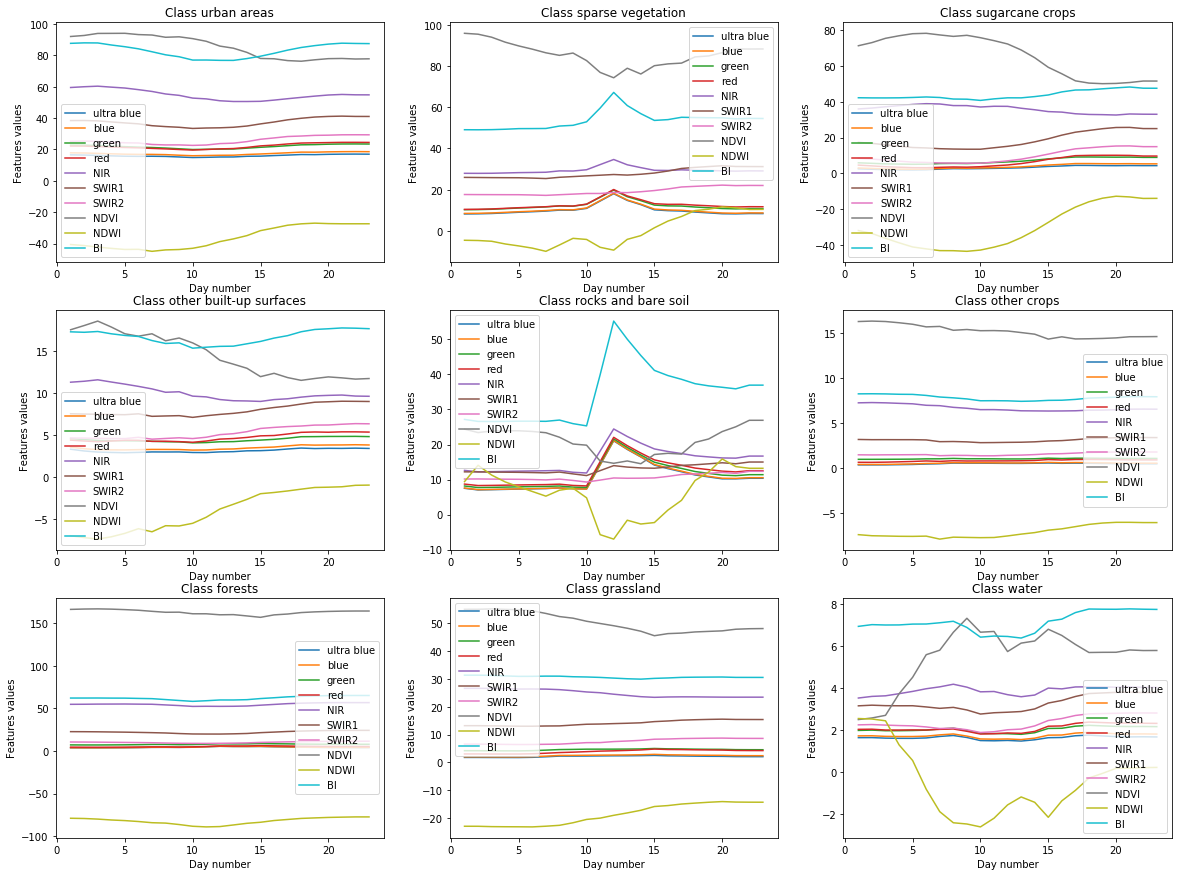

In [74]:
fig, axs = plt.subplots(3,3, figsize=(20,15))

for idx in range(len(list_of_per_class_features_mean)):
    
    i, j = idx % 3, int(idx / 3)
    
    values = list_of_per_class_features_mean[idx]/N
    
    standard_devs = list_of_per_class_features_std[idx] - np.square(values)
    
    for idx_f, feature in enumerate(FEATURES):
        
        x = np.arange(1,24)
        y = values[idx_f, :]
        
        e = np.sqrt(standard_devs[idx_f, :])
        
        axs[i, j].errorbar(x, y, label=feature)
        

    axs[i, j].set_title(f"Class {CLASSES[idx]}")
    axs[i, j].set_ylabel("Features values")
    axs[i, j].set_xlabel("Day number")
    axs[i, j].legend()
    
    

As we can see there, a few different classes see their features be highly disturbed through the days (e.g the *water* class or the *rocks and bare soil* are the most noticeable). Oppositely, the *forests* and *crops* classes are pretty steady in their results. 

This apparent diversity in the variation of the features for each class is a **good sign**, it should not be too hard for an automatic classifier to be able to discriminate them from each other.

## Classifiers

### LSTM

We will first work with Deep Learning oriented solution and try implementing an LSTM on this data. Let's setup our working environment with the adequate hyperparameters.

In [78]:
##  Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Flatten

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau 

## Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

LR = 0.001
BATCH_SIZE = 256
EPOCHS = 50
VAL_SIZE = 0.1

#### Setting up the data (splitting into training and validation sets)

In [83]:
scaler_coord = StandardScaler()

In [84]:
# Formatting the X data
data_train = data.to_numpy()
#data_train = minmax_scaler.fit_transform(data_train)

data_coord = coord.to_numpy().astype(np.int32).reshape(-1, 2)
data_coord = scaler_coord.fit_transform(data_coord)


X = data_train.reshape((NUM_OF_PIXELS, 23, NUM_OF_FEATURES)).astype(np.int32)


# Formatting the y data
classes_train = classes_val.to_numpy().astype(np.uint8)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(classes_train).astype(np.uint8)

In [85]:
# Splitting x and y into training and validation sets
indices = np.arange(X.shape[0])
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X, y, indices, test_size = VAL_SIZE)

In [46]:
X_train_formatted = [
    X_train, 
    #X_train
    data_coord[idx_train]
]
X_train_formatted.extend([np.expand_dims(X_train[:,:,i], axis=2) for i in range(10)])

X_val_formatted = [
    X_val, 
    #X_val
    data_coord[idx_val]
]
X_val_formatted.extend([np.expand_dims(X_val[:,:,i], axis=2) for i in range(10)])

#### Setting up the model

In [88]:
model_filename = "tiselac-lstm-{epoch:02d}-{val_loss:.2f}.h5"

callbacks = [
    ModelCheckpoint(
        os.path.join("models/", model_filename),
        monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch'),
    #EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience = 6),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.00001)


]

<img src="static/img/tiselac_paper_ibm.png">

In [93]:
def get_multivariate_model():
    """
        Treats the data of each band as a multimodal time serie
    """
    input_lstm = Input((23, 10))
    #lstm = LSTM(512, input_shape=(23, 10))(input_lstm)
    
    conv = Conv1D(32, 3, padding="same", activation="relu")(input_lstm)
    conv = Conv1D(32, 3, padding="same", activation="relu")(conv)
    conv = Conv1D(32, 3, padding="same", activation="relu")(conv)
    flat = Flatten()(conv)
    
    return Model(inputs=input_lstm,outputs=flat)

def get_coordinates_model():
    """
        Treats the pixel coordinates on the image
    """
    input_seq = Input(shape=(2,))

    #x = Conv1D(32, 3, padding="same", activation="relu")(input_seq)
    #x = MaxPooling1D()(x)
    #x = Conv1D(32, 3, padding="same", activation="relu")(x)
    
    return Model(inputs=input_seq, outputs=input_seq)

def get_univariate_models():
    """
        Treats each band independently then concatenate models in one single
    """
    # Models built for each band
    inputs = [Input((23,1)) for _ in range(10)]
    convs1 = [Conv1D(8,3,padding="same",activation="relu")(inputs[i]) for i in range(10)]    
    pools = [MaxPooling1D()(convs1[i]) for i in range(10)]
    convs2 = [Conv1D(4,3,padding="same",activation="relu")(pools[i]) for i in range(10)]
    pools = [MaxPooling1D()(convs2[i]) for i in range(10)]
    flatt = [Flatten()(pools[i]) for i in range(10)]
    
    
    # First concatenate: each band at the first convolutional level
    conca1 = Concatenate()(convs1)
    conv1 = Conv1D(8,10,padding="same",activation="relu")(conca1)
    flatt1 = Flatten()(conv1)
    flatt.append(flatt1)
    
    # Second concatenate: each band at the second convolutional level
    conca2 = Concatenate()(convs2)
    conv2 = Conv1D(4,10,padding="same",activation="relu")(conca2)
    flatt2 = Flatten()(conv2)
    flatt.append(flatt2)
    
    # Third and last concatenate after every flatten, adding the process of the first and second concats
    conca3 = Concatenate()(flatt)
    
    return Model(inputs=inputs, outputs=conca3)
    
# Merging inputs from the time series and the pixel position
mult_model = get_multivariate_model()
coord_model = get_coordinates_model()
univ_models = get_univariate_models()


merged = Concatenate(axis=-1)([
    mult_model.output, 
    coord_model.output, 
    univ_models.output])

x = Dense(256, activation="relu")(merged)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
out = Dense(NUM_OF_CLASSES, activation='softmax')(x)

model = Model(inputs=[
    mult_model.input, 
    coord_model.input, 
    univ_models.input], outputs=[out])

opt = Adam(LR)

model.compile(opt, loss="categorical_crossentropy",
    metrics=['categorical_accuracy'])

In [94]:
model.fit(
    X_train_formatted, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
    callbacks=callbacks, 
    validation_data=(X_val_formatted, y_val))

Train on 73542 samples, validate on 8172 samples
Epoch 1/50
72960/73542 [============================>.] - ETA: 0s - loss: 1.8876 - categorical_accuracy: 0.6004
Epoch 00001: val_loss did not improve from 0.26887
73542/73542 [==============================] - 7s 101us/sample - loss: 1.8805 - categorical_accuracy: 0.6010 - val_loss: 0.7627 - val_categorical_accuracy: 0.7769
Epoch 2/50
73216/73542 [============================>.] - ETA: 0s - loss: 0.8437 - categorical_accuracy: 0.7525
Epoch 00002: val_loss did not improve from 0.26887
73542/73542 [==============================] - 3s 43us/sample - loss: 0.8434 - categorical_accuracy: 0.7527 - val_loss: 0.6266 - val_categorical_accuracy: 0.8074
Epoch 3/50
72448/73542 [============================>.] - ETA: 0s - loss: 0.7101 - categorical_accuracy: 0.7897 ETA: 0s - loss: 0.7173 - categori
Epoch 00003: val_loss did not improve from 0.26887
73542/73542 [==============================] - 4s 49us/sample - loss: 0.7092 - categorical_accuracy: 0.

Epoch 26/50
72192/73542 [============================>.] - ETA: 0s - loss: 0.1295 - categorical_accuracy: 0.9595
Epoch 00026: val_loss did not improve from 0.26887
73542/73542 [==============================] - 3s 41us/sample - loss: 0.1290 - categorical_accuracy: 0.9597 - val_loss: 0.2790 - val_categorical_accuracy: 0.9268
Epoch 27/50
73472/73542 [============================>.] - ETA: 0s - loss: 0.1233 - categorical_accuracy: 0.9619
Epoch 00027: val_loss did not improve from 0.26887
73542/73542 [==============================] - 3s 41us/sample - loss: 0.1233 - categorical_accuracy: 0.9619 - val_loss: 0.2795 - val_categorical_accuracy: 0.9271
Epoch 28/50
72704/73542 [============================>.] - ETA: 0s - loss: 0.1213 - categorical_accuracy: 0.9621
Epoch 00028: val_loss did not improve from 0.26887

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-05.
73542/73542 [==============================] - 3s 42us/sample - loss: 0.1211 - categorical_accuracy: 0.9621 - val_loss:

#### Testing the model

We will now test the model on the provided dataset and use a F1 Score metric for it (provided by Sk-Learn).

In [97]:
from sklearn.metrics import f1_score, confusion_matrix

data_test_np = data_test.to_numpy()
#data_test_np = data_test_np.transform(minmax_scaler)

X_test = data_test_np.reshape((data_test_np.shape[0], 23, NUM_OF_FEATURES)).astype(np.float32)
coord_test_np = coord_test.to_numpy().astype(np.int32).reshape(-1, 2)
coord_test_np = scaler_coord.transform(coord_test_np)

univariate_bands = [np.expand_dims(X_test[:,:,i], axis=2) for i in range(10)]

X_test = [
    X_test, 
    #X_test
    coord_test_np
]
X_test.extend(univariate_bands)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) +1

We evaluate the F1 score to compare with other teams result in the context of the TiSeLaC challenge.

In [96]:
f1_score(y_test.flatten(), y_pred, average="weighted")

0.9306486923254769

To have better insights on which classes are often misclassified, we will plot a confusion matrix using seaborn and sklearn.

In [114]:
m = confusion_matrix(y_test.flatten(), y_pred)
m_pd = pd.DataFrame(m)
classes_as_dict = {i: CLASSES[i] for i in range(9)}
m_pd = m_pd.rename(columns=classes_as_dict, index=classes_as_dict)

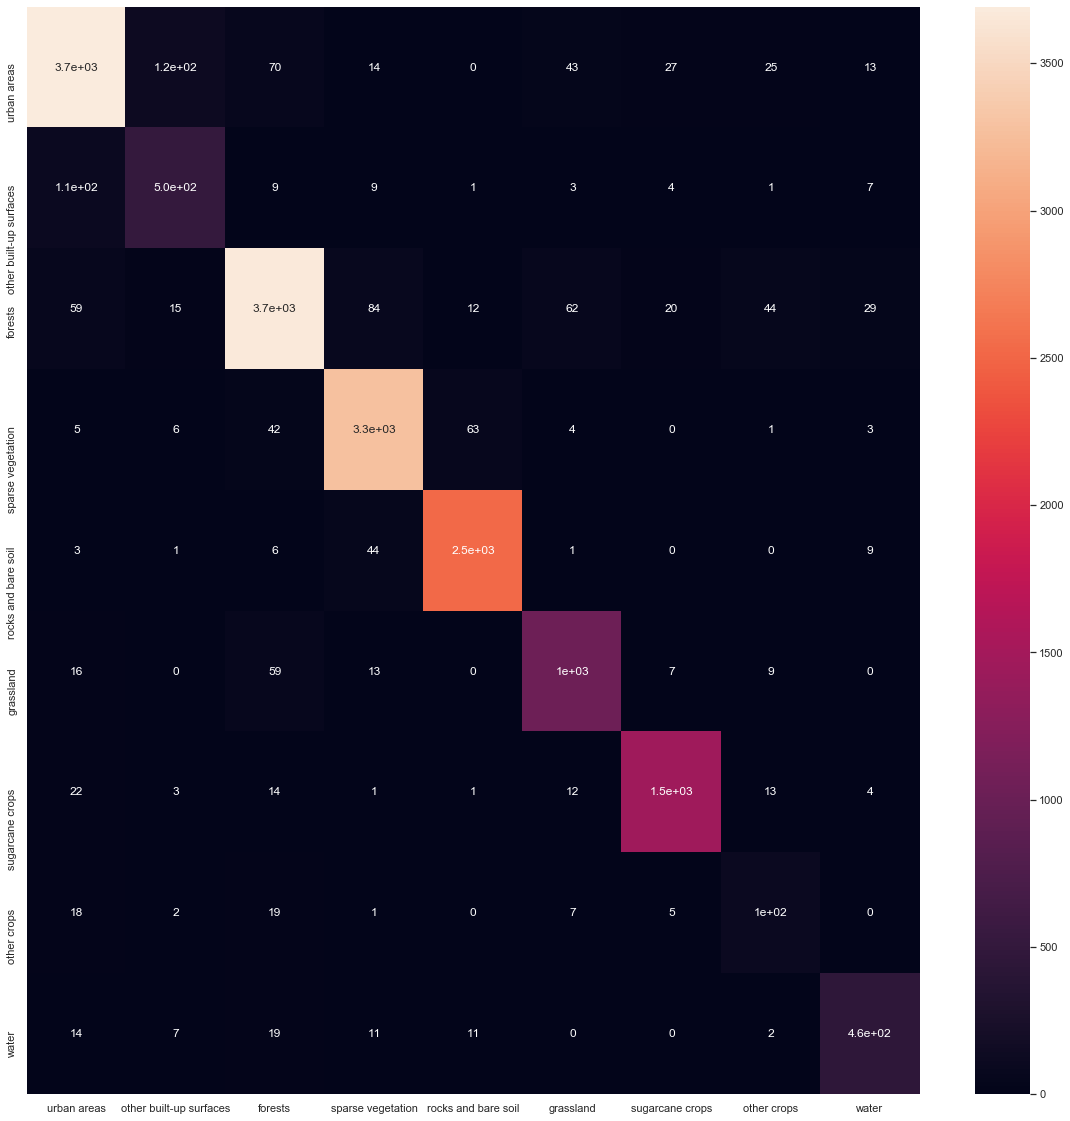

In [116]:
figs, axs = plt.subplots(figsize=(20,20))
sns.heatmap(m_pd, ax=axs, annot=True)

### 1D-CNN

For this part, we will implement the Multi-Scale Convolutional Neural Networks presented in the following paper: [Multi-Scale Convolutional Neural Networks for Time SeriesClassification](https://arxiv.org/pdf/1603.06995.pdf)

The architecture looks like this:

<figure>
       <img src="static/img/mcnn.png" alt="mcnn" width="1000">
          <figcaption>Fig.3 - Overall architecture of MCNN</figcaption>
</figure>

We will first setup our constants and imports

In [138]:
from tensorflow.keras.layers import Conv1D, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Model

LR = 0.01
BATCH_SIZE = 256
EPOCHS = 100
VAL_SIZE = 0.2
DOWN_SAMPLING_FACTOR = 2
DOWN_SAMPLING_SIZE = int(np.ceil(NUM_OF_DAYS)/DOWN_SAMPLING_FACTOR) + 1
SMOOTH_SIZE = 4

scaler = StandardScaler()

#### Setting up the data

In [139]:
idx = np.arange(X.shape[0])

# Formatting the X data
data_train = data.to_numpy()
X = data_train.reshape((NUM_OF_PIXELS, 23, NUM_OF_FEATURES)).astype(np.int64)
coord_np = coord.to_numpy().astype(np.int32).reshape(-1, 2)


# Formatting the y data
classes_train = classes_val.to_numpy().astype(np.uint8)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(classes_train).astype(np.uint8)

In [140]:
# Splitting x and y into training and validation sets
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X, y, idx, test_size = VAL_SIZE)

After splitting the image data, we take care of the pixel positions that we scale without data leak by fitting the transformer only to the training set.

In [141]:
coord_train = coord_np[idx_train]
coord_train = scaler.fit_transform(coord_train)

coord_val = scaler.transform(coord_np[idx_val])

#### Setting up the model

Here, we first create three simple models to extract features that may be specific to our three different scale of time series:
 - The original time series
 - The smoothed time series
 - The down sampled time series

They are then concatenated and a new Convolutional layer is added before jumping to 3 fully connected layers. This model, in the same way than the LSTM, is pretty light in parameters, making its training relatively harder, hense requiring more advanced finetuning.

In [142]:
def get_base_model(input_len, fsize=6):
    #this base model represents the convolution + pooling phase (there will be three of it)

    input_seq = Input(shape=(input_len, 10))

    x = Conv1D(40, fsize, padding="same", activation="relu")(input_seq)
    x = MaxPooling1D()(x)
    model = Model(inputs=input_seq, outputs=x)
    
    return model

def get_coord_model():
    input_c = Input(shape=(2,))
    model = Model(inputs=input_c, outputs=input_c)
    
    return model

#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def get_1D_CNN():

    input_original = Input(shape=(23, 10))
    input_multifrequency = Input(shape=(23 , 10))
    input_down_sampling = Input(shape=(DOWN_SAMPLING_SIZE, 10))
    
    base_net_original = get_base_model(23)
    base_net_multifrequency = get_base_model(23)
    base_net_down_sampling = get_base_model(DOWN_SAMPLING_SIZE, fsize=3)
    
    embedding_original = base_net_original(input_original)
    embedding_multifrequency = base_net_multifrequency(input_multifrequency)
    embedding_down_sampling = base_net_down_sampling(input_down_sampling)
    
    merged = Concatenate(axis=1)([embedding_original, embedding_multifrequency, embedding_down_sampling])#concatenate all the outputs
    
    conv = Conv1D(40, 6, padding="same", activation="relu")(merged)
    x = GlobalMaxPooling1D()(conv)
    
    coord_model = get_coord_model()
    #concatenating the coord model and the CNN-extracted features
    x = Concatenate(axis=-1)([x, coord_model.output])
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    #x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    
    out = Dense(NUM_OF_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=[input_original, input_multifrequency, input_down_sampling, coord_model.input], outputs=out)
    return model

#### Creating the data generator

We have to take care of the different scale of data by making sure that the generator, when taking one time series as an input, outputs three of them, one of which being the original, the two others having been through their own sets of processing.

In [143]:
def smoothing(row):
    # given a row of shape (23,10), smoothes all 10 feature according to the smoothing factor (mean over a SMOOTH_SIZE window)
    
    to_smooth = np.copy(row)
    
    for i in range(row.shape[1]):
        for j in range(row.shape[0]):
            
            smoothing_indices = np.array([k % row.shape[0] for k in range(int(j - SMOOTH_SIZE / 2), int(j + SMOOTH_SIZE / 2 + 1))])
            
            acc = 0
            for idx in smoothing_indices:
                acc += row[idx,i]
                
            to_smooth[j,i] = acc / SMOOTH_SIZE
            
    return to_smooth

def down_sampling(row):
    new_row = []
    
    for j in range(0, len(row)+1, DOWN_SAMPLING_FACTOR):
        new_row.append(row[j])
    
    return np.array(new_row)

In [144]:
def data_generator(X, y, input_shape=(23,10), batch_size=64):
    """
        X is a tuple (X_train, X_coord) where X_train is the pixels data and X_coord their coordinates
    """
    X_train, X_coord = X
    
    while True:
        
        for i in range(0, len(X_train), batch_size):
            
            upper = min(i+batch_size, len(X_train)-1)
            
            batch = np.copy(X_train[i:upper])
            smoothed = np.copy(X_train[i:upper])
            down_sampled = np.zeros((len(batch),DOWN_SAMPLING_SIZE,input_shape[1]))
            coords = np.copy(X_coord[i:upper])
            
            for row_idx in range(len(batch)):
                smoothed[row_idx, :] = smoothing(X_train[row_idx, :])
                down_sampled[row_idx, :] = down_sampling(X_train[row_idx, :])
            
            
            X_batch = [
                batch,smoothed,down_sampled, coords
            ]
            
            y_batch = y[i:upper]
                
            yield X_batch, y_batch

#### Training our model

In [145]:
train_gen = data_generator(
    (X_train,coord_train), y_train, batch_size=BATCH_SIZE)
val_gen = data_generator(
    (X_val,coord_val), y_val, batch_size=BATCH_SIZE)
train_steps = round(len(X_train) / BATCH_SIZE) + 1
val_steps = round(len(X_val) / BATCH_SIZE) + 1

In [146]:
model = get_1D_CNN()

opt = Adam(LR)
model.compile(opt, loss="categorical_crossentropy",
    metrics=['categorical_accuracy'])

In [147]:
model_filename = "tiselac-mcnn-{epoch:02d}-{val_loss:.2f}.h5"

callbacks = [
    ModelCheckpoint(
        os.path.join("models/", model_filename),
        monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch'),
    #EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience = 5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.00001)

]

In [148]:
model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/100
255/256 [============================>.] - ETA: 0s - loss: 1.0584 - categorical_accuracy: 0.6468
Epoch 00001: val_loss improved from inf to 0.98179, saving model to models/tiselac-mcnn-01-0.98.h5
256/256 [==============================] - 133s 520ms/step - loss: 1.0580 - categorical_accuracy: 0.6469 - val_loss: 0.9818 - val_categorical_accuracy: 0.6693
Epoch 2/100
255/256 [============================>.] - ETA: 0s - loss: 0.7532 - categorical_accuracy: 0.7669
Epoch 00002: val_loss improved from 0.98179 to 0.74482, saving model to models/tiselac-mcnn-02-0.74.h5
256/256 [==============================] - 126s 494ms/step - loss: 0.7533 - categorical_accuracy: 0.7669 - val_loss: 0.7448 - val_categorical_accuracy: 0.7684
Epoch 3/100
255/256 [============================>.] - ETA: 0s - loss: 0.6624 - categorical_accuracy: 0.7942
Epoch 00003: val_loss improved from 0.74482 to 0.73857, saving model to models/tiselac-mcnn-03-0.74.h5
256/256 [==============================] - 125s 49

Epoch 25/100
255/256 [============================>.] - ETA: 0s - loss: 0.3428 - categorical_accuracy: 0.8897
Epoch 00025: val_loss did not improve from 0.39883
256/256 [==============================] - 141s 550ms/step - loss: 0.3428 - categorical_accuracy: 0.8897 - val_loss: 0.3993 - val_categorical_accuracy: 0.8751
Epoch 26/100
255/256 [============================>.] - ETA: 0s - loss: 0.3390 - categorical_accuracy: 0.8919
Epoch 00026: val_loss improved from 0.39883 to 0.39149, saving model to models/tiselac-mcnn-26-0.39.h5
256/256 [==============================] - 139s 544ms/step - loss: 0.3391 - categorical_accuracy: 0.8919 - val_loss: 0.3915 - val_categorical_accuracy: 0.8775
Epoch 27/100
255/256 [============================>.] - ETA: 0s - loss: 0.3349 - categorical_accuracy: 0.8924
Epoch 00027: val_loss improved from 0.39149 to 0.39101, saving model to models/tiselac-mcnn-27-0.39.h5
256/256 [==============================] - 138s 538ms/step - loss: 0.3349 - categorical_accurac

Epoch 49/100
255/256 [============================>.] - ETA: 0s - loss: 0.2997 - categorical_accuracy: 0.9034
Epoch 00049: val_loss improved from 0.37898 to 0.37818, saving model to models/tiselac-mcnn-49-0.38.h5
256/256 [==============================] - 145s 566ms/step - loss: 0.2995 - categorical_accuracy: 0.9034 - val_loss: 0.3782 - val_categorical_accuracy: 0.8835
Epoch 50/100
255/256 [============================>.] - ETA: 0s - loss: 0.2992 - categorical_accuracy: 0.9037
Epoch 00050: val_loss did not improve from 0.37818
256/256 [==============================] - 142s 556ms/step - loss: 0.2993 - categorical_accuracy: 0.9037 - val_loss: 0.3792 - val_categorical_accuracy: 0.8832
Epoch 51/100
255/256 [============================>.] - ETA: 0s - loss: 0.2997 - categorical_accuracy: 0.9031
Epoch 00051: val_loss did not improve from 0.37818
256/256 [==============================] - 140s 547ms/step - loss: 0.2997 - categorical_accuracy: 0.9031 - val_loss: 0.3800 - val_categorical_accur

Epoch 75/100
255/256 [============================>.] - ETA: 0s - loss: 0.2998 - categorical_accuracy: 0.9030
Epoch 00075: val_loss did not improve from 0.37818
256/256 [==============================] - 149s 581ms/step - loss: 0.2998 - categorical_accuracy: 0.9030 - val_loss: 0.3806 - val_categorical_accuracy: 0.8832
Epoch 76/100
255/256 [============================>.] - ETA: 0s - loss: 0.2975 - categorical_accuracy: 0.9042
Epoch 00076: val_loss did not improve from 0.37818
256/256 [==============================] - 146s 569ms/step - loss: 0.2975 - categorical_accuracy: 0.9042 - val_loss: 0.3796 - val_categorical_accuracy: 0.8835
Epoch 77/100
255/256 [============================>.] - ETA: 0s - loss: 0.2992 - categorical_accuracy: 0.9028
Epoch 00077: val_loss did not improve from 0.37818
256/256 [==============================] - 142s 555ms/step - loss: 0.2991 - categorical_accuracy: 0.9029 - val_loss: 0.3783 - val_categorical_accuracy: 0.8836
Epoch 78/100
255/256 [==================

#### Testing the model

We will now test the model on the provided dataset and use a F1 Score metric for it (provided by Sk-Learn).

In [156]:
from sklearn.metrics import f1_score

data_test_np = data_test.to_numpy()

X_test = data_test_np.reshape((data_test_np.shape[0], 23, NUM_OF_FEATURES)).astype(np.float32)
coord_test_np = coord_test.to_numpy().astype(np.int32).reshape(-1, 2)
coord_test_np = scaler.transform(coord_test_np)

test_gen = data_generator((X_test,coord_test_np), y_test, batch_size=BATCH_SIZE)
test_steps = round(len(X_test) / BATCH_SIZE) + 1

In [157]:
y_pred = model.predict_generator(test_gen, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1) +1

In [161]:
f1_score(y_test.flatten()[:17972], y_pred, average="weighted")

0.8906295859287777

### Advanced Classifiers

Based on [this paper (Ismail Fawaz, H., Forestier, G., Weber, J. et al, 2019)](https://arxiv.org/pdf/1809.04356.pdf), I retained a number of the models compared.

#### 1. Multi Channel Deep Convolutional Neural Network

Detailed in [this paper (Zheng et al., 2014, 2016)](http://staff.ustc.edu.cn/~cheneh/paper_pdf/2016/YiZheng-FCS2016.pdf), this architecture want to exploit a presumed independence between the different features of the MTS data by applying convolution independently (in parallel) on each dimension of the input. 

In [75]:
from tensorflow.keras.layers import Flatten, AveragePooling1D

In [97]:
def get_channel_model(ts_length):

    input_seq = Input(shape=(ts_length,1))

    x = Conv1D(12, 12, padding="same", activation="relu")(input_seq)
    x = MaxPooling1D()(x)
    x = Conv1D(24, 8, padding='same', activation="relu")(x)
    x = MaxPooling1D()(x)
    model = Model(inputs=input_seq, outputs=x)
    
    return model

def get_MCDCNN():
    
    input_models = [get_channel_model(23) for i in range(10)]
    
    merged = Concatenate(axis=1)([channel.input for channel in input_models])#concatenate all the outputs
    x = Flatten()(merged)
    x = Dense(732, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(NUM_OF_CLASSES, activation="softmax")(x)
    
    mcdcnn_model = Model([channel.input for channel in input_models], x)
    return mcdcnn_model

In [98]:
LR = 0.01
opt = SGD(LR, decay=0.0005)

mcdcnn_model = get_MCDCNN()
mcdcnn_model.compile(opt, loss="categorical_crossentropy",metrics=["accuracy"])

##### Starting training...

In [99]:
def data_generator_mcdcnn(X, y, input_shape=(10,23,1), batch_size=64):
    
    while True:
        
        for i in range(0, len(X), batch_size):
            
            upper = min(i+batch_size, len(X)-1)
            
            batch = np.copy(X[i:upper])

            batch = batch.reshape((batch.shape[0],)+input_shape)
            
            y_batch = y[i:upper]
                
            yield [batch[:,i,:,:] for i in range(10)], y_batch
            

In [107]:
model_filename = "tiselac-mcdcnn-{epoch:02d}-{val_loss:.2f}.h5"

callbacks = [
    ModelCheckpoint(
        os.path.join("models/", model_filename),
        monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch'),
    EarlyStopping(monitor='val_loss', min_delta = 1e-4, patience = 5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.00001)

]

In [108]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SIZE)

In [109]:
BATCH_SIZE = 256
EPOCHS = 120

train_gen = data_generator_mcdcnn(X_train, y_train, batch_size=BATCH_SIZE)
val_gen = data_generator_mcdcnn(X_val, y_val, batch_size=BATCH_SIZE)
train_steps = round(len(X_train) / BATCH_SIZE) + 1
val_steps = round(len(X_val) / BATCH_SIZE) + 1

mcdcnn_model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/120
286/288 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.8502
Epoch 00001: val_loss improved from inf to 0.40923, saving model to models/tiselac-mcdcnn-01-0.41.h5
288/288 [==============================] - 8s 27ms/step - loss: 0.4676 - accuracy: 0.8501 - val_loss: 0.4092 - val_accuracy: 0.8722
Epoch 2/120
287/288 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.8484
Epoch 00002: val_loss did not improve from 0.40923
288/288 [==============================] - 8s 26ms/step - loss: 0.4703 - accuracy: 0.8484 - val_loss: 0.4123 - val_accuracy: 0.8707
Epoch 3/120
285/288 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8503
Epoch 00003: val_loss did not improve from 0.40923
288/288 [==============================] - 8s 28ms/step - loss: 0.4696 - accuracy: 0.8503 - val_loss: 0.4126 - val_accuracy: 0.8709
Epoch 4/120
287/288 [============================>.] - ETA: 0s - loss: 0.4687 - accuracy: 0.8508
Epoch 00004: 

##### Testing the model

We will now test the model on the provided dataset and use a F1 Score metric for it (provided by Sk-Learn).

In [110]:
from sklearn.metrics import f1_score

data_test_np = data_test.to_numpy()

X_test = data_test_np.reshape((data_test_np.shape[0], 23, NUM_OF_FEATURES)).astype(np.float32)

test_gen = data_generator_mcdcnn(X_test, y_test, batch_size=BATCH_SIZE)
test_steps = round(len(X_test) / BATCH_SIZE) + 1

In [111]:
y_pred = mcdcnn_model.predict_generator(test_gen, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1) +1

In [112]:
test_gen = data_generator_mcdcnn(X_test, y_test, batch_size=BATCH_SIZE)

In [113]:
f1_score(y_test.flatten()[:-1], y_pred[:17972], average="weighted")

0.8676438262617016

#### 2. Time-CNN

Seen as an improvement of the MCDCNN method, by training multivariate time series jointly for better feature extraction, this architecture has been developed in [this paper (Zhao B, Lu H, Chen S, Liu J, Wu D , 2017)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7870510).

Multiple unique characteristics are notable:
 - A MSE loss used with a sigmoid output layer
 - Use of Average pooling instead of Max Pooling
 - No Pooling layer after the last convolution layer before the feature extracted classification

In [122]:
def get_time_cnn(input_shape=(23,10)):
    
    input_l = Input(input_shape)
    x = Conv1D(24, 8, activation="relu")(input_l)
    x = AveragePooling1D(pool_size=3)(x)
    x = Conv1D(24, 4, activation="relu")(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(NUM_OF_CLASSES, activation='sigmoid')(x)
    
    model = Model(input_l, x)
    return model

In [123]:
LR = 0.001
opt = Adam(LR, decay=0)

time_cnn = get_time_cnn()
time_cnn.compile(opt, loss="mse")

In [124]:
model_filename = "tiselac-time-cnn-{epoch:02d}-{val_loss:.2f}.h5"

callbacks = [
    ModelCheckpoint(
        os.path.join("models/", model_filename),
        monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch'),
    EarlyStopping(monitor='val_loss', min_delta = 1e-4, patience = 5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.00001)

]

In [125]:
BATCH_SIZE = 128
EPOCHS = 2000

time_cnn.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Train on 73542 samples, validate on 8172 samples
Epoch 1/2000
73216/73542 [============================>.] - ETA: 0s - loss: 0.0642
Epoch 00001: val_loss improved from inf to 0.03568, saving model to models/tiselac-time-cnn-01-0.04.h5
73542/73542 [==============================] - 4s 52us/sample - loss: 0.0642 - val_loss: 0.0357
Epoch 2/2000
72960/73542 [============================>.] - ETA: 0s - loss: 0.0355
Epoch 00002: val_loss improved from 0.03568 to 0.03346, saving model to models/tiselac-time-cnn-02-0.03.h5
73542/73542 [==============================] - 3s 41us/sample - loss: 0.0355 - val_loss: 0.0335
Epoch 3/2000
73088/73542 [============================>.] - ETA: 0s - loss: 0.0326
Epoch 00003: val_loss improved from 0.03346 to 0.03106, saving model to models/tiselac-time-cnn-03-0.03.h5
73542/73542 [==============================] - 3s 40us/sample - loss: 0.0326 - val_loss: 0.0311
Epoch 4/2000
72192/73542 [============================>.] - ETA: 0s - loss: 0.0309
Epoch 00004: v

Epoch 31/2000
72448/73542 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 00031: val_loss improved from 0.02141 to 0.02140, saving model to models/tiselac-time-cnn-31-0.02.h5
73542/73542 [==============================] - 3s 39us/sample - loss: 0.0220 - val_loss: 0.0214


##### Testing the model

We will now test the model on the provided dataset and use a F1 Score metric for it (provided by Sk-Learn).

In [126]:
from sklearn.metrics import f1_score

data_test_np = data_test.to_numpy()

X_test = data_test_np.reshape((data_test_np.shape[0], 23, NUM_OF_FEATURES)).astype(np.float32)


In [127]:
y_pred = time_cnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) +1

In [128]:
f1_score(y_test.flatten(), y_pred, average="weighted")

0.8746766654130611